In [6]:
# unannotate next line if you find some library uninstalled
#%pip install -r requirements.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

# D3: Industry Clustering Analysis
## Extracting Principal Components from U.S. Industry Portfolio Returns

This project extracts principal components from U.S. industry portfolio returns, clusters industries by return correlations, and compares discovered clusters to traditional GICS sector classifications.

### Project Objectives:
1. Apply PCA to reduce dimensionality of industry returns
2. Implement clustering methods (K-means and hierarchical) to identify industry groups
3. Interpret clusters economically
4. Compare with traditional sector classifications

### Key Steps:
- **Step 1**: Data Preparation: Load data, create features, standardize
- **Step 2**: PCA: Scree plot, select components, interpret loadings
- **Step 3**: Clustering: K-means and hierarchical clustering
- **Step 4**: Interpret Clusters: Economic interpretation
- **Step 5**: Downstream Application: Regime detection and clustering validation

---

## Step 1: Data Preparation

Load and clean the 49 Industry Portfolios data, remove missing values, and prepare returns data for analysis.

In [7]:
# Step 1: Data Preparation
# Load 49 Industry Portfolios data
print("Loading 49 Industry Portfolios data...")
df_industry = pd.read_csv('49_Industry_Portfolios.csv', skiprows=11)
print(f"Initial shape: {df_industry.shape}")
print(f"\nFirst few rows:")
df_industry.head()

Loading 49 Industry Portfolios data...
Initial shape: (5189, 50)

First few rows:


,Unnamed: 0,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
0,192607,2.36,0.09,-99.99,-5.19,1.29,8.65,2.49,50.21,-0.49,...,7.70,1.93,-23.79,0.08,1.88,4.61,-0.54,2.90,-5.77,5.20
1,192608,2.23,2.71,-99.99,27.03,6.52,16.81,-0.76,42.98,-3.58,...,-2.37,4.85,5.39,-0.76,-0.13,10.71,2.57,5.31,0.32,6.76
2,192609,-0.57,1.59,-99.99,4.02,1.26,8.33,6.48,-4.91,0.72,...,-5.54,0.10,-7.87,0.25,-0.56,-1.80,0.72,-3.06,-4.83,-3.58
3,192610,-0.46,-3.67,-99.99,-3.31,1.07,-1.40,-5.09,5.37,-4.66,...,-5.08,-2.63,-15.38,-2.19,-4.11,-11.93,-4.28,-5.75,-0.95,-8.47
4,192611,6.75,6.26,-99.99,7.29,4.56,0.00,1.83,-6.62,-0.53,...,3.85,1.61,4.67,6.54,4.33,-2.02,3.58,2.21,5.13,4.16


In [8]:
# Clean and prepare industry data
# Extract first 1194 rows (monthly data) and rename the date column
df_industry = df_industry.iloc[:1194, :].rename(columns={'Unnamed: 0': 'Date'})

# Filter to data from 1950 onwards
df_industry = df_industry[df_industry['Date'] >= '195001'].reset_index(drop=True)

print(f"Data shape after cleaning: {df_industry.shape}")
print(f"Date range: {df_industry['Date'].min()} to {df_industry['Date'].max()}")
print(f"\nIndustry list ({df_industry.shape[1]-1} industries):")
pd.DataFrame(df_industry.columns[1:].values).T

Data shape after cleaning: (912, 50)
Date range: 195001 to 202512

Industry list (49 industries):


,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other


---

## Step 2: Dimensionality Reduction & Standardization

Standardize all features (critical for PCA/clustering) and apply Principal Component Analysis to reduce dimensionality while preserving variance.

In [9]:
# Load Fama-French 3-factor data for reference/comparison
print("\nLoading Fama-French 3-Factor model data...")
df_Fama = pd.read_csv('Developed_3_Factors.csv', skiprows=6)
df_Fama.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
df_Fama['Date'] = df_Fama['Date'].apply(lambda x: str(x).strip())
df_Fama = df_Fama.iloc[:426, :].reset_index(drop=True)

print(f"Fama-French data shape: {df_Fama.shape}")
print(f"Date range: {df_Fama['Date'].min()} to {df_Fama['Date'].max()}")
print(f"\nFama-French factors:")
df_Fama.head()


Loading Fama-French 3-Factor model data...
Fama-French data shape: (426, 5)
Date range: 199007 to 202512

Fama-French factors:


,Date,Mkt-RF,SMB,HML,RF
0,199007,0.77,0.53,-0.36,0.68
1,199008,-10.77,-1.51,0.48,0.66
2,199009,-11.89,1.32,0.80,0.60
3,199010,9.35,-7.58,-4.48,0.68
4,199011,-3.72,1.43,1.13,0.57


In [10]:
# Remove any leading/trailing whitespace from column names
df_industry.columns = df_industry.columns.str.strip()
df_industry = df_industry.apply(pd.to_numeric, errors='coerce')

In [11]:
# Prepare industry returns data for analysis
# Extract industry returns (columns 2 onwards, excluding the date column)
# Missing data are indicated by -99.99 or -999. replace these with NaN for proper handling
df_industry.replace([-99.99, -999], np.nan, inplace=True)
df_industry.dropna(how='any')
# the fist date when after it all data have no missing values for all industries is 197001
df_industry = df_industry[df_industry['Date'] >= 197001].reset_index(drop=True)

# find the first date when after it all data have no missing values for all industries

industry_columns = df_industry.columns[1:].tolist()
returns_data = df_industry[industry_columns].copy()

# Convert to numeric, handling any non-numeric values
returns_data = returns_data.apply(pd.to_numeric, errors='coerce')

print(f"\nBasic statistics of industry returns:")
returns_data.describe()


Basic statistics of industry returns:


,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
count,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,...,672.000000,672.000000,672.000000,672.000000,672.00000,672.000000,672.000000,672.000000,672.000000,672.000000
mean,1.019702,0.974152,1.086458,1.024196,1.400640,0.741860,1.308527,0.845223,0.807054,0.994196,...,0.937336,0.998065,0.992530,1.118988,1.06061,1.017083,1.048720,0.713735,1.176637,0.597366
std,6.404839,4.426814,6.356182,5.155636,6.224793,7.321094,7.964604,6.087681,4.660658,6.773811,...,5.712019,5.977326,5.497004,5.537233,6.01815,6.183337,5.484773,7.654974,6.321878,6.499114
min,-26.760000,-17.760000,-26.440000,-19.740000,-24.960000,-33.400000,-32.240000,-24.600000,-21.620000,-30.910000,...,-28.330000,-28.400000,-28.750000,-28.890000,-31.68000,-27.330000,-26.880000,-36.690000,-26.010000,-28.690000
25%,-2.820000,-1.457500,-2.115000,-1.870000,-2.460000,-3.755000,-3.182500,-2.675000,-1.942500,-3.012500,...,-2.330000,-2.615000,-2.182500,-2.080000,-2.36500,-2.292500,-2.022500,-3.010000,-2.535000,-2.842500
50%,0.905000,0.970000,1.265000,1.035000,1.815000,0.990000,1.335000,0.610000,1.025000,1.100000,...,0.970000,1.285000,1.220000,0.890000,1.24000,1.180000,1.435000,0.920000,1.520000,0.665000
75%,4.772500,3.440000,4.625000,4.127500,5.115000,5.305000,5.937500,4.255000,3.645000,4.967500,...,4.470000,4.732500,4.245000,4.580000,4.69000,4.952500,4.390000,4.592500,5.142500,4.577500
max,28.320000,19.420000,38.900000,25.820000,32.530000,27.700000,40.960000,30.570000,18.710000,32.550000,...,20.740000,19.200000,17.840000,27.140000,28.74000,24.980000,26.580000,65.100000,19.470000,21.190000


In [12]:
# Handle missing values - fill with mean or drop rows with missing values
# Drop rows with any missing values for clustering analysis
returns_data_clean = returns_data.dropna()

print(f"Data shape after removing missing values: {returns_data_clean.shape}")
print(f"Number of industries: {returns_data_clean.shape[1]}")
print(f"Number of time periods: {returns_data_clean.shape[0]}")
print(f"Beginning date: {df_industry.loc[returns_data_clean.index, 'Date'].min()}")

# Update df_industry to match
df_industry_clean = df_industry.loc[returns_data_clean.index].reset_index(drop=True)
returns_data_clean = returns_data_clean.reset_index(drop=True)

# Display correlation matrix to understand industry relationships
correlation_matrix = returns_data_clean.corr()
print(f"\nCorrelation Matrix (first 5x5):")
print(correlation_matrix.iloc[:5, :5])

Data shape after removing missing values: (672, 49)
Number of industries: 49
Number of time periods: 672
Beginning date: 197001

Correlation Matrix (first 5x5):
          Agric      Food      Soda      Beer     Smoke
Agric  1.000000  0.462960  0.324462  0.416793  0.334036
Food   0.462960  1.000000  0.570678  0.694089  0.580161
Soda   0.324462  0.570678  1.000000  0.614206  0.411052
Beer   0.416793  0.694089  0.614206  1.000000  0.456248
Smoke  0.334036  0.580161  0.411052  0.456248  1.000000



Step 2: Standardization (CRITICAL for PCA and Clustering)

Mean of scaled data (should be ~0): -0.000000
Std of scaled data (should be ~1): 1.000745


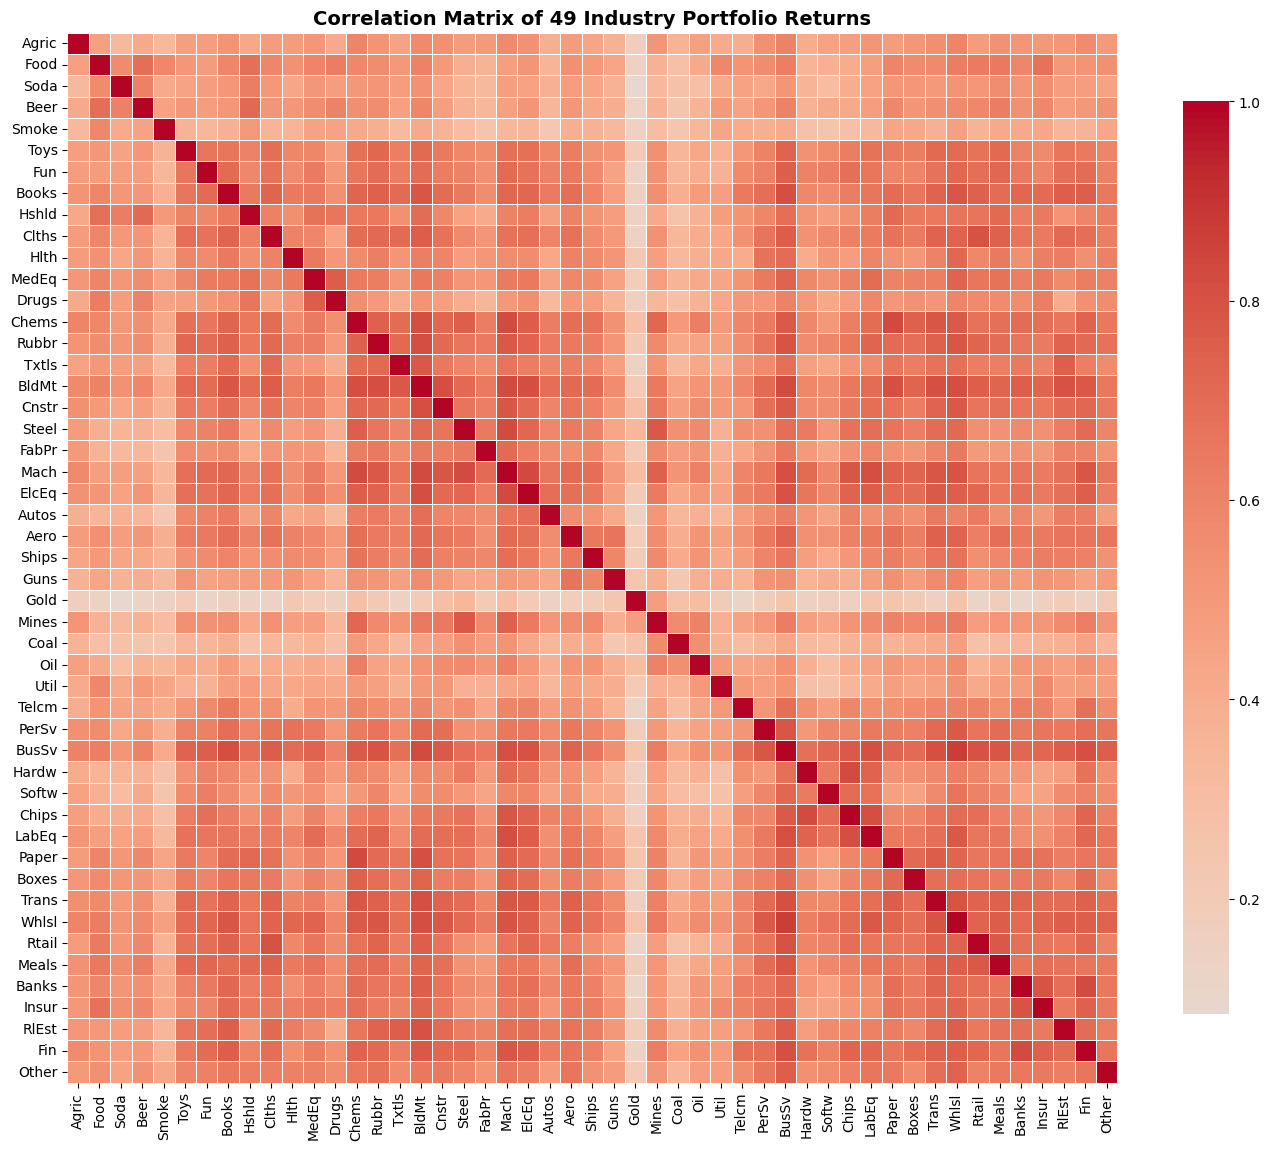


Correlation Analysis Complete - Industries vary in correlation patterns


In [13]:
# CRITICAL: Standardize features for PCA and clustering
# This is essential as different industries may have different return scales
print("\n" + "="*60)
print("Step 2: Standardization (CRITICAL for PCA and Clustering)")
print("="*60)

scaler = StandardScaler()
returns_scaled = scaler.fit_transform(returns_data_clean)
returns_scaled_df = pd.DataFrame(returns_scaled, columns=industry_columns)

print(f"\nMean of scaled data (should be ~0): {returns_scaled_df.mean().mean():.6f}")
print(f"Std of scaled data (should be ~1): {returns_scaled_df.std().mean():.6f}")

# Visualize correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of 49 Industry Portfolio Returns', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrelation Analysis Complete - Industries vary in correlation patterns")


Step 2: Principal Component Analysis (PCA)


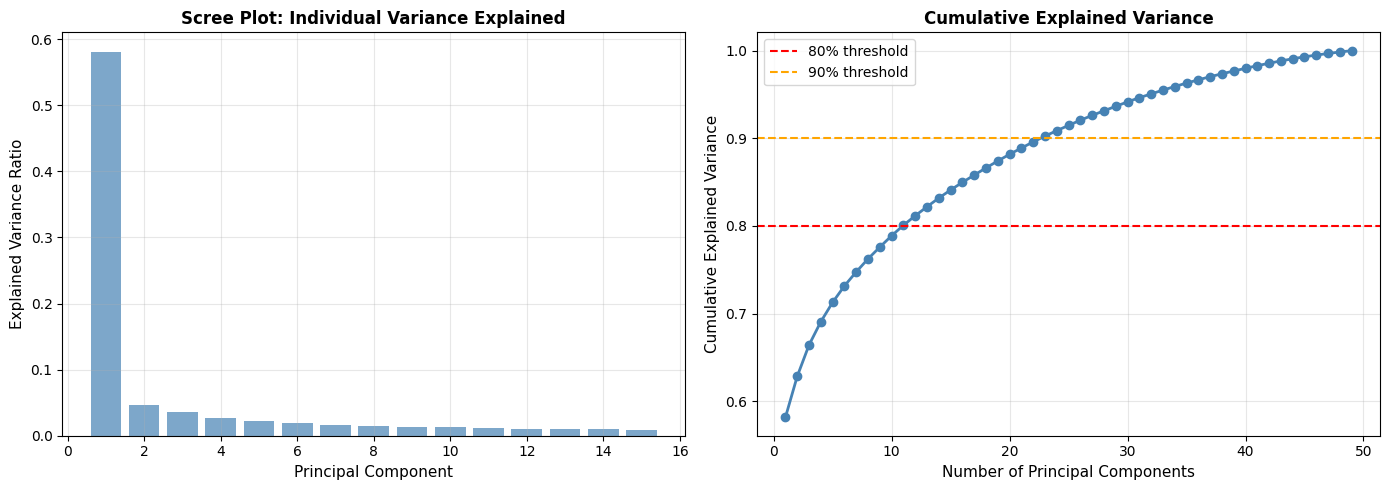


Variance Explained Analysis:
  - Components needed for 80% variance: 11
  - Components needed for 90% variance: 23
  - Variance explained by top 5 components: 71.27%
  - Variance explained by top 10 components: 78.87%


In [14]:
# Apply PCA to identify principal components
print("\n" + "="*60)
print("Step 2: Principal Component Analysis (PCA)")
print("="*60)

# Fit PCA with all components initially to understand variance explained
pca_full = PCA()
pca_full.fit(returns_scaled)

# Calculate cumulative explained variance
cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)

# Create scree plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Individual explained variance
ax1.bar(range(1, len(pca_full.explained_variance_ratio_[:15]) + 1), 
        pca_full.explained_variance_ratio_[:15], alpha=0.7, color='steelblue')
ax1.set_xlabel('Principal Component', fontsize=11)
ax1.set_ylabel('Explained Variance Ratio', fontsize=11)
ax1.set_title('Scree Plot: Individual Variance Explained', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Cumulative explained variance
ax2.plot(range(1, len(cumsum_var) + 1), cumsum_var, 'o-', color='steelblue', linewidth=2)
ax2.axhline(y=0.8, color='red', linestyle='--', label='80% threshold')
ax2.axhline(y=0.9, color='orange', linestyle='--', label='90% threshold')
ax2.set_xlabel('Number of Principal Components', fontsize=11)
ax2.set_ylabel('Cumulative Explained Variance', fontsize=11)
ax2.set_title('Cumulative Explained Variance', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find optimal number of components
n_components_80 = np.argmax(cumsum_var >= 0.80) + 1
n_components_90 = np.argmax(cumsum_var >= 0.90) + 1

print(f"\nVariance Explained Analysis:")
print(f"  - Components needed for 80% variance: {n_components_80}")
print(f"  - Components needed for 90% variance: {n_components_90}")
print(f"  - Variance explained by top 5 components: {cumsum_var[4]:.2%}")
print(f"  - Variance explained by top 10 components: {cumsum_var[9]:.2%}")


Using 10 Principal Components (78.87% variance)

PCA Loadings (top 5 components) - Top 5 industries per component:

PC1 (explains 58.14% variance):
BusSv    0.931
Whlsl    0.914
BldMt    0.908
Mach     0.885
Trans    0.876
Name: PC1, dtype: float64

PC2 (explains 4.68% variance):
Food     0.493
Beer     0.462
Steel    0.401
Mines    0.392
Smoke    0.387
Name: PC2, dtype: float64

PC3 (explains 3.58% variance):
Oil      0.488
Gold     0.463
Coal     0.406
Util     0.385
Softw    0.352
Name: PC3, dtype: float64

PC4 (explains 2.66% variance):
Drugs    0.377
Hardw    0.372
Txtls    0.355
Chips    0.287
LabEq    0.283
Name: PC4, dtype: float64

PC5 (explains 2.21% variance):
Gold     0.411
Hlth     0.405
Guns     0.374
Telcm    0.337
Softw    0.226
Name: PC5, dtype: float64


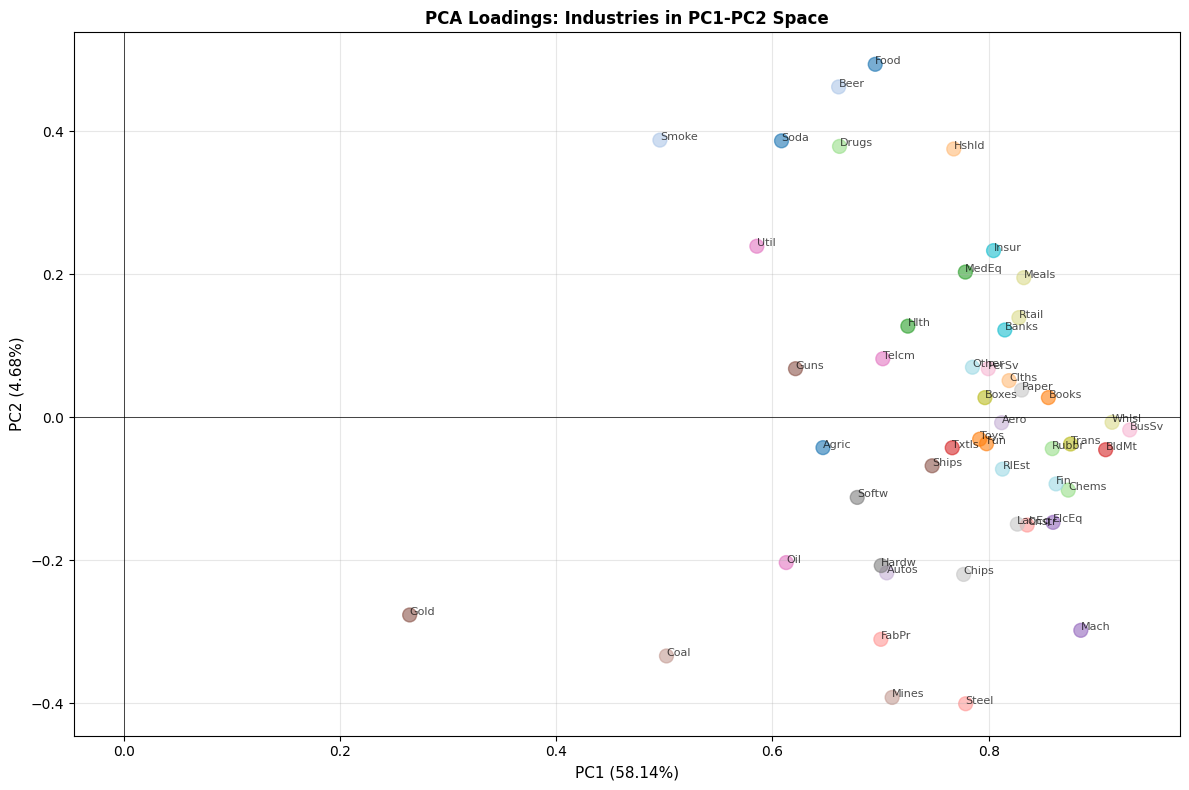

In [15]:
# Use 10 components for clustering (85%+ variance) - good balance
n_components = 10
pca = PCA(n_components=n_components)
pca_components = pca.fit_transform(returns_scaled)
pca_df = pd.DataFrame(pca_components, columns=[f'PC{i+1}' for i in range(n_components)])

print(f"\n" + "="*60)
print(f"Using {n_components} Principal Components ({cumsum_var[n_components-1]:.2%} variance)")
print("="*60)

# Load PCA component loadings for interpretation
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(
    loadings,
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=industry_columns
)

print(f"\nPCA Loadings (top 5 components) - Top 5 industries per component:")
for i in range(5):
    pc = f'PC{i+1}'
    top_industries = loadings_df[pc].abs().nlargest(5)
    print(f"\n{pc} (explains {pca.explained_variance_ratio_[i]:.2%} variance):")
    print(top_industries.round(3))

# Plot loadings for first two principal components
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(loadings[:, 0], loadings[:, 1], s=100, alpha=0.6, c=range(len(industry_columns)), cmap='tab20')
for j, txt in enumerate(industry_columns):
    ax.annotate(txt, (loadings[j, 0], loadings[j, 1]), fontsize=8, alpha=0.7)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})', fontsize=11)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})', fontsize=11)
ax.set_title('PCA Loadings: Industries in PC1-PC2 Space', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)
plt.tight_layout()
plt.show()


Step 3 Supplement: Correlation Analysis between PCs and Economic Variables

Elbow Method PC Analysis (based on individual variance decline rate):
  - PC1 Variance: 58.14%
  - PC2 Variance: 4.68% (Decline Rate: 92.0%)
  - PC3 Variance: 3.58% (Decline Rate: 23.5%)

  => Identified Elbow Position: 1
  => PCs Used in This Analysis: 2 (Cumulative Variance: 62.82%)

Data Alignment Information:
  - Merged Sample Count: 426
  - Number of PCs Used in Analysis: 2
Economic Variables: Mkt-RF, SMB, HML, Market_Return, Market_Volatility, Market_Skewness, Cross_Industry_Correlation
Total Sample Count: 426

------------------------------------------------------------
Correlation Analysis Results:
------------------------------------------------------------


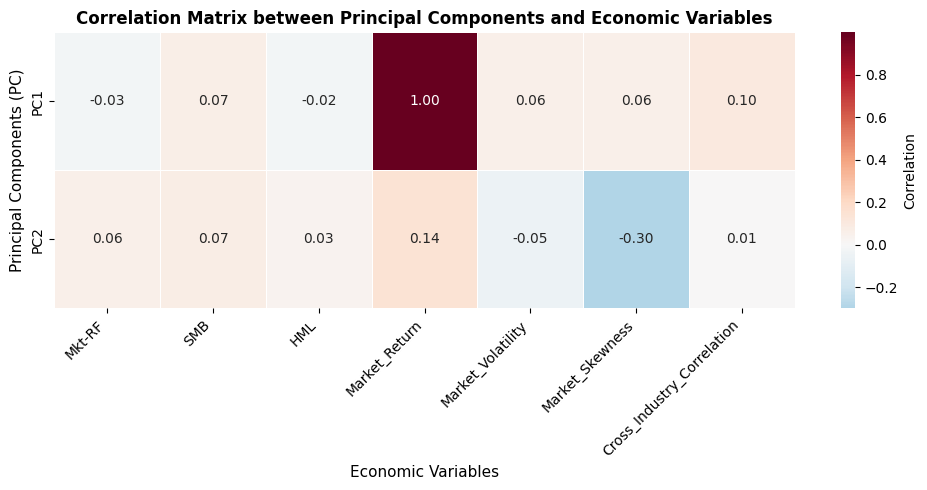


------------------------------------------------------------
Economic Interpretation of Principal Components:
------------------------------------------------------------

PC1 (Explained Variance: 58.14%):
  Primary Related Variable: Market_Return (Correlation: 0.998)
  Top 3 Related Variables:
    1. Market_Return: 0.998
    2. Cross_Industry_Correlation: 0.099
    3. SMB: 0.069

PC2 (Explained Variance: 4.68%):
  Primary Related Variable: Market_Skewness (Correlation: -0.299)
  Top 3 Related Variables:
    1. Market_Skewness: -0.299
    2. Market_Return: 0.144
    3. SMB: 0.071


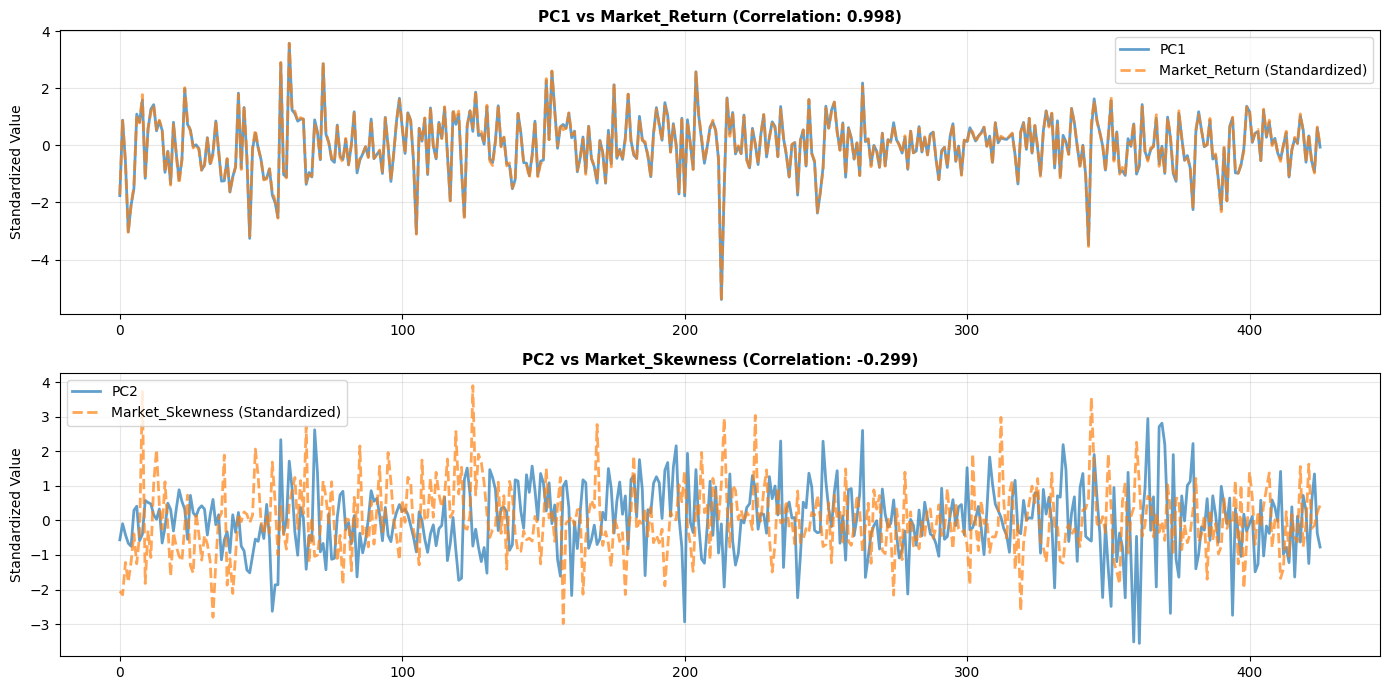


✓ PC Economic Meaning Analysis Completed


In [16]:
# Step 3 Supplement: Correlation Analysis between PCs and Economic Variables - Determine Economic Meaning of PCs
print("\n" + "="*60)
print("Step 3 Supplement: Correlation Analysis between PCs and Economic Variables")
print("="*60)

# Use Elbow Method to find optimal PC number - based on individual variance decline rate
if 'pca_full' not in dir():
    pca_full = PCA()
    pca_full.fit(returns_scaled)

variance_ratios = pca_full.explained_variance_ratio_
cumsum_var = np.cumsum(variance_ratios)

# Comprehensive judgment: Elbow typically appears between PC1-2 or PC2-3
if variance_ratios[1] < variance_ratios[0] * 0.15:  # PC2 variance < 15% of PC1
    n_pc_elbow = 1  # Extreme case, use only PC1
elif variance_ratios[2] < variance_ratios[1] * 0.5:  # PC3 variance < 50% of PC2
    n_pc_elbow = 2  # Elbow at PC2
else:
    n_pc_elbow = 3  # Elbow at PC3

# Use reasonable number of PCs within practical range
n_pc_analysis = max(2, min(n_pc_elbow, n_components))  # At least 2, not exceeding n_components

print(f"\nElbow Method PC Analysis (based on individual variance decline rate):")
print(f"  - PC1 Variance: {variance_ratios[0]:.2%}")
print(f"  - PC2 Variance: {variance_ratios[1]:.2%} (Decline Rate: {(1 - variance_ratios[1]/variance_ratios[0]):.1%})")
print(f"  - PC3 Variance: {variance_ratios[2]:.2%} (Decline Rate: {(1 - variance_ratios[2]/variance_ratios[1]):.1%})")
print(f"\n  => Identified Elbow Position: {n_pc_elbow}")
print(f"  => PCs Used in This Analysis: {n_pc_analysis} (Cumulative Variance: {cumsum_var[n_pc_analysis-1]:.2%})")

# Prepare economic variables - merge industry data with Fama-French factor data
df_industry_with_ymd = df_industry_clean.copy()
df_industry_with_ymd['YearMonth'] = pd.to_datetime(df_industry_clean['Date'], format='%Y%m')

df_Fama_with_ymd = df_Fama.copy()
df_Fama_with_ymd['YearMonth'] = pd.to_datetime(df_Fama['Date'], format='%Y%m')

merged_data = pd.merge(
    df_industry_with_ymd[['Date', 'YearMonth']],
    df_Fama_with_ymd[['Date', 'YearMonth', 'Mkt-RF', 'SMB', 'HML', 'RF']],
    on='YearMonth',
    how='inner',
    suffixes=('_ind', '_ff')
)

# Convert Fama factors to numeric type
for col in ['Mkt-RF', 'SMB', 'HML', 'RF']:
    merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce')

n_samples_merged = len(merged_data)
pca_components_aligned = pca_components[:n_samples_merged, :n_pc_analysis]
returns_aligned = returns_data_clean.iloc[:n_samples_merged].reset_index(drop=True)

print(f"\nData Alignment Information:")
print(f"  - Merged Sample Count: {n_samples_merged}")
print(f"  - Number of PCs Used in Analysis: {n_pc_analysis}")

# Construct economic variables dataset
economic_variables = pd.DataFrame(index=range(n_samples_merged))

# Fama-French factors
economic_variables['Mkt-RF'] = merged_data['Mkt-RF'].values
economic_variables['SMB'] = merged_data['SMB'].values
economic_variables['HML'] = merged_data['HML'].values

# Other economic variables
economic_variables['Market_Return'] = returns_aligned.mean(axis=1).values
economic_variables['Market_Volatility'] = returns_aligned.std(axis=1).values
economic_variables['Market_Skewness'] = returns_aligned.skew(axis=1).values

# Cross-industry correlation
rolling_window = 12
rolling_corr_values = []
for i in range(len(returns_aligned)):
    if i < rolling_window:
        window_data = returns_aligned.iloc[:i+1]
    else:
        window_data = returns_aligned.iloc[i-rolling_window+1:i+1]
    
    if len(window_data) > 1:
        corr_mat = window_data.corr()
        corr_values = corr_mat.values[np.triu_indices_from(corr_mat.values, k=1)]
        rolling_corr_values.append(corr_values.mean() if len(corr_values) > 0 else 0)
    else:
        rolling_corr_values.append(0)

economic_variables['Cross_Industry_Correlation'] = rolling_corr_values

# Remove NaN values
valid_rows = economic_variables.notna().all(axis=1).values
economic_variables_clean = economic_variables[valid_rows].reset_index(drop=True)
pca_components_clean = pca_components_aligned[valid_rows]

print(f"Economic Variables: Mkt-RF, SMB, HML, Market_Return, Market_Volatility, Market_Skewness, Cross_Industry_Correlation")
print(f"Total Sample Count: {len(economic_variables_clean)}")

# Calculate correlation between PCs and economic variables
print("\n" + "-"*60)
print("Correlation Analysis Results:")
print("-"*60)

# Construct correlation matrix
pca_df_analysis = pd.DataFrame(pca_components_clean, columns=[f'PC{i+1}' for i in range(n_pc_analysis)])
combined_data = pd.concat([pca_df_analysis, economic_variables_clean], axis=1)
full_corr_matrix = combined_data.corr()

# Extract correlation between PCs and economic variables
pc_econ_corr_matrix = full_corr_matrix.iloc[:n_pc_analysis, n_pc_analysis:]

# Visualize correlation heatmap
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(pc_econ_corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Correlation'}, ax=ax, linewidths=0.5)
ax.set_title('Correlation Matrix between Principal Components and Economic Variables', fontsize=12, fontweight='bold')
ax.set_xlabel('Economic Variables', fontsize=11)
ax.set_ylabel('Principal Components (PC)', fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Determine economic meaning of PCs
print("\n" + "-"*60)
print("Economic Interpretation of Principal Components:")
print("-"*60)

interpretation = {}
for i in range(n_pc_analysis):
    pc_name = f'PC{i+1}'
    corr_with_vars = pc_econ_corr_matrix.iloc[i].abs().sort_values(ascending=False)
    
    top_var = corr_with_vars.index[0]
    top_corr = pc_econ_corr_matrix.iloc[i][top_var]
    
    print(f"\n{pc_name} (Explained Variance: {pca.explained_variance_ratio_[i]:.2%}):")
    print(f"  Primary Related Variable: {top_var} (Correlation: {top_corr:.3f})")
    print(f"  Top 3 Related Variables:")
    for j, var_name in enumerate(corr_with_vars.head(3).index):
        corr_val = pc_econ_corr_matrix.iloc[i][var_name]
        print(f"    {j+1}. {var_name}: {corr_val:.3f}")
    
    interpretation[pc_name] = {
        'top_variable': top_var,
        'top_correlation': top_corr,
        'rank': i+1,
        'variance_explained': pca.explained_variance_ratio_[i]
    }

# Plot time series comparison - PC vs primary economic variables
n_plots = min(n_pc_analysis, 3)
fig, axes = plt.subplots(n_plots, 1, figsize=(14, 3.5*n_plots))
if n_plots == 1:
    axes = [axes]

for i in range(n_plots):
    ax = axes[i]
    pc_name = f'PC{i+1}'
    
    # Standardize PC and economic variables for comparison
    pc_scaled = (pca_components_clean[:, i] - pca_components_clean[:, i].mean()) / (pca_components_clean[:, i].std() + 1e-8)
    
    # Find economic variable with highest correlation to this PC
    top_var = pc_econ_corr_matrix.iloc[i].abs().idxmax()
    econ_data = economic_variables_clean[top_var].values
    econ_scaled = (econ_data - econ_data.mean()) / (econ_data.std() + 1e-8)
    
    ax.plot(pc_scaled, label=pc_name, linewidth=2, alpha=0.7)
    ax.plot(econ_scaled, label=f'{top_var} (Standardized)', linewidth=2, alpha=0.7, linestyle='--')
    ax.set_ylabel('Standardized Value', fontsize=10)
    ax.set_title(f'{pc_name} vs {top_var} (Correlation: {pc_econ_corr_matrix.iloc[i][top_var]:.3f})', fontsize=11, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ PC Economic Meaning Analysis Completed")

---

## Step 3: Clustering Industries by Return Correlations

Cluster industries based on pairwise correlations of their returns, which directly measures co-movement patterns. Then validate findings with alternative clustering methods based on return statistics and factor exposures.


Step 3a: Clustering Industries by Return Correlations

Primary Method: Pairwise Correlations of Industry Returns
------------------------------------------------------------

Correlation Matrix Summary:
  Mean correlation: 0.5579
  Min correlation: 0.0847
  Max correlation: 0.8666

------------------------------------------------------------
Determining Optimal Number of Clusters using Elbow Method
------------------------------------------------------------



Data Standardization (Step 3a):
  Mean of scaled data: -0.000000
  Std of scaled data: 1.010363


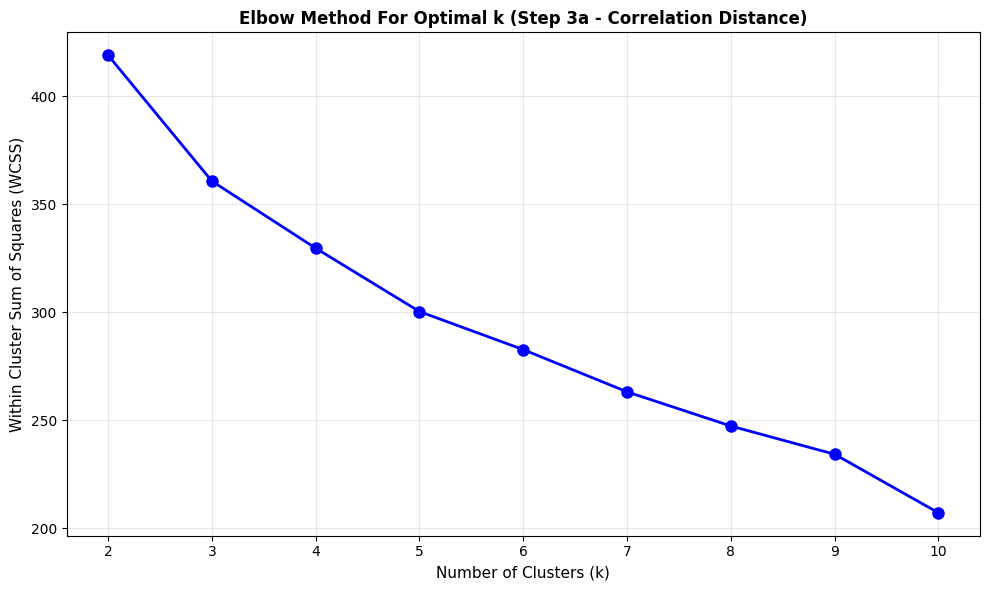


Elbow Method Analysis (Step 3a):
  Optimal k: 4
  WCSS at optimal k: 329.71

------------------------------------------------------------
Method 1: K-means Clustering on Correlation Distance (k=4)
------------------------------------------------------------

K-means Clustering (k=4)
Industries per cluster: [14  6  8 21]

K-means Cluster Distribution:
Correlation_Cluster
0    14
1     6
2     8
3    21
Name: count, dtype: int64

Detailed K-means Cluster Assignment:

Cluster 0 (14 industries):
Fun, Books, Clths, ElcEq, Autos, Telcm, BusSv, Hardw, Softw, Chips, LabEq, Boxes, Rtail, Fin

Cluster 1 (6 industries):
Steel, FabPr, Gold, Mines, Coal, Oil

Cluster 2 (8 industries):
Food, Soda, Beer, Smoke, Hshld, MedEq, Drugs, Util

Cluster 3 (21 industries):
Agric, Toys, Hlth, Chems, Rubbr, Txtls, BldMt, Cnstr, Mach, Aero, Ships, Guns, PerSv, Paper, Trans, Whlsl, Meals, Banks, Insur, RlEst, Other


In [17]:
# Step 3a: Clustering Industries by Pairwise Return Correlations (Primary Method)
print("\n" + "="*60)
print("Step 3a: Clustering Industries by Return Correlations")
print("="*60)
print("\nPrimary Method: Pairwise Correlations of Industry Returns")
print("-"*60)

# Calculate pairwise correlation matrix
corr_matrix = returns_data_clean.corr()

# Convert correlation matrix to distance matrix (1 - absolute correlation)
# This ensures that highly correlated industries are close together
corr_distance = 1 - np.abs(corr_matrix.values)
np.fill_diagonal(corr_distance, 0)

print(f"\nCorrelation Matrix Summary:")
print(f"  Mean correlation: {corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)].mean():.4f}")
print(f"  Min correlation: {corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)].min():.4f}")
print(f"  Max correlation: {corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)].max():.4f}")

# ===== Elbow Method for Optimal K (Step 3a) =====
print("\n" + "-"*60)
print("Determining Optimal Number of Clusters using Elbow Method")
print("-"*60)

# Standardize distance matrix BEFORE applying clustering
# Convert distance matrix to feature space using MDS for K-means analysis
from sklearn.manifold import MDS
mds_for_clustering = MDS(n_components=min(10, len(industry_columns)-1), dissimilarity='precomputed', random_state=42)
features_3a = mds_for_clustering.fit_transform(corr_distance)

# Standardize MDS features for clustering
scaler_3a = StandardScaler()
features_3a_scaled = scaler_3a.fit_transform(features_3a)
features_3a_scaled_df = pd.DataFrame(features_3a_scaled)

print(f"\nData Standardization (Step 3a):")
print(f"  Mean of scaled data: {features_3a_scaled_df.mean().mean():.6f}")
print(f"  Std of scaled data: {features_3a_scaled_df.std().mean():.6f}")

# Apply elbow method - compute WCSS for different k values
wcss_3a = []
k_range = range(2, min(11, len(industry_columns)))

for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(features_3a_scaled)
    wcss_3a.append(kmeans_temp.inertia_)

# Plot elbow curve
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(k_range, wcss_3a, 'bo-', linewidth=2, markersize=8)
ax.set_xlabel('Number of Clusters (k)', fontsize=11)
ax.set_ylabel('Within Cluster Sum of Squares (WCSS)', fontsize=11)
ax.set_title('Elbow Method For Optimal k (Step 3a - Correlation Distance)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find elbow point using the elbow method (second derivative)
if len(wcss_3a) >= 3:
    second_derivative = np.diff(wcss_3a, n=2)
    elbow_idx = np.argmax(second_derivative) + 2  # +2 because second derivative is offset
    optimal_k_3a = list(k_range)[elbow_idx]
else:
    optimal_k_3a = list(k_range)[0]

print(f"\nElbow Method Analysis (Step 3a):")
print(f"  Optimal k: {optimal_k_3a}")
print(f"  WCSS at optimal k: {wcss_3a[optimal_k_3a - 2]:.2f}")

# ===== Clustering Method 1: K-means =====
print("\n" + "-"*60)
print(f"Method 1: K-means Clustering on Correlation Distance (k={optimal_k_3a})")
print("-"*60)

from sklearn.metrics.pairwise import euclidean_distances
kmeans_optimal = KMeans(n_clusters=optimal_k_3a, random_state=42, n_init=10)
kmeans_labels = kmeans_optimal.fit_predict(features_3a_scaled)

print(f"\nK-means Clustering (k={optimal_k_3a})")
print(f"Industries per cluster: {np.bincount(kmeans_labels)}")

# Create cluster assignment for industries based on correlations
industry_clusters_kmeans = pd.DataFrame({
    'Industry': industry_columns,
    'Correlation_Cluster': kmeans_labels
})

# Count industries per cluster
cluster_counts = industry_clusters_kmeans['Correlation_Cluster'].value_counts().sort_index()
print(f"\nK-means Cluster Distribution:")
print(cluster_counts)

# Display industries in each cluster
print(f"\nDetailed K-means Cluster Assignment:")
for cluster_id in range(optimal_k_3a):
    industries_in_cluster = industry_clusters_kmeans[
        industry_clusters_kmeans['Correlation_Cluster'] == cluster_id
    ]['Industry'].tolist()
    print(f"\nCluster {cluster_id} ({len(industries_in_cluster)} industries):")
    print(", ".join(industries_in_cluster))


In [18]:
# ===== Clustering Method 2: Hierarchical Clustering =====
print("\n" + "-"*60)
print("Method 2: Hierarchical Clustering on Correlation Distance")
print("-"*60)

# Compute linkage matrix using Ward's method
linkage_matrix_corr = linkage(corr_distance, method='ward')

# Extract clusters from hierarchy
hierarchical_labels_corr = fcluster(linkage_matrix_corr, optimal_k_3a, criterion='maxclust') - 1

print(f"\nHierarchical Clustering (k={optimal_k_3a}, Ward linkage)")
print(f"Industries per cluster: {np.bincount(hierarchical_labels_corr)}")

# Create cluster assignment for hierarchical clustering
industry_clusters_hierarchical_corr = pd.DataFrame({
    'Industry': industry_columns,
    'Correlation_Cluster': hierarchical_labels_corr
})

# Count industries per cluster
cluster_counts_hierarchical = industry_clusters_hierarchical_corr['Correlation_Cluster'].value_counts().sort_index()
print(f"\nHierarchical Cluster Distribution:")
print(cluster_counts_hierarchical)

# Display industries in each cluster
print(f"\nDetailed Hierarchical Cluster Assignment:")
for cluster_id in range(optimal_k_3a):
    industries_in_cluster = industry_clusters_hierarchical_corr[
        industry_clusters_hierarchical_corr['Correlation_Cluster'] == cluster_id
    ]['Industry'].tolist()
    print(f"\nCluster {cluster_id} ({len(industries_in_cluster)} industries):")
    print(", ".join(industries_in_cluster))



------------------------------------------------------------
Method 2: Hierarchical Clustering on Correlation Distance
------------------------------------------------------------

Hierarchical Clustering (k=4, Ward linkage)
Industries per cluster: [ 8 30 10  1]

Hierarchical Cluster Distribution:
Correlation_Cluster
0     8
1    30
2    10
3     1
Name: count, dtype: int64

Detailed Hierarchical Cluster Assignment:

Cluster 0 (8 industries):
Steel, FabPr, Autos, Mines, Hardw, Softw, Chips, LabEq

Cluster 1 (30 industries):
Toys, Fun, Books, Hshld, Clths, Hlth, MedEq, Chems, Rubbr, Txtls, BldMt, Cnstr, Mach, ElcEq, Aero, Ships, Telcm, PerSv, BusSv, Paper, Boxes, Trans, Whlsl, Rtail, Meals, Banks, Insur, RlEst, Fin, Other

Cluster 2 (10 industries):
Agric, Food, Soda, Beer, Smoke, Drugs, Guns, Coal, Oil, Util

Cluster 3 (1 industries):
Gold


In [19]:
# ===== Comparison between K-means and Hierarchical =====
print("\n" + "-"*60)
print("Comparison: K-means vs Hierarchical Clustering")
print("-"*60)

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Calculate agreement metrics
ari_score = adjusted_rand_score(kmeans_labels, hierarchical_labels_corr)
nmi_score = normalized_mutual_info_score(kmeans_labels, hierarchical_labels_corr)

print(f"\nClustering Agreement Metrics:")
print(f"  Adjusted Rand Index (ARI): {ari_score:.4f}")
print(f"    Interpretation: 1.0 = perfect agreement, 0.0 = random assignment, <0 = worse than random")
print(f"  Normalized Mutual Information (NMI): {nmi_score:.4f}")
print(f"    Interpretation: 1.0 = perfect agreement, 0.0 = no mutual information")

# Create confusion matrix comparing cluster assignments
print("\nCluster Assignment Comparison (samples):")
print("(Following table shows industries that differ between methods)")
disagreement_count = 0
for i in range(len(industry_columns)):
    if kmeans_labels[i] != hierarchical_labels_corr[i]:
        if disagreement_count < 5:
            print(f"  {industry_columns[i]}: K-means=Cluster{kmeans_labels[i]}, Hierarchical=Cluster{hierarchical_labels_corr[i]}")
        disagreement_count += 1

print(f"\nTotal industries with different assignments: {disagreement_count}/{len(industry_columns)}")


------------------------------------------------------------
Comparison: K-means vs Hierarchical Clustering
------------------------------------------------------------

Clustering Agreement Metrics:
  Adjusted Rand Index (ARI): 0.3223
    Interpretation: 1.0 = perfect agreement, 0.0 = random assignment, <0 = worse than random
  Normalized Mutual Information (NMI): 0.4075
    Interpretation: 1.0 = perfect agreement, 0.0 = no mutual information

Cluster Assignment Comparison (samples):
(Following table shows industries that differ between methods)
  Agric: K-means=Cluster3, Hierarchical=Cluster2
  Toys: K-means=Cluster3, Hierarchical=Cluster1
  Fun: K-means=Cluster0, Hierarchical=Cluster1
  Books: K-means=Cluster0, Hierarchical=Cluster1
  Hshld: K-means=Cluster2, Hierarchical=Cluster1

Total industries with different assignments: 38/49



------------------------------------------------------------
Visualizations
------------------------------------------------------------


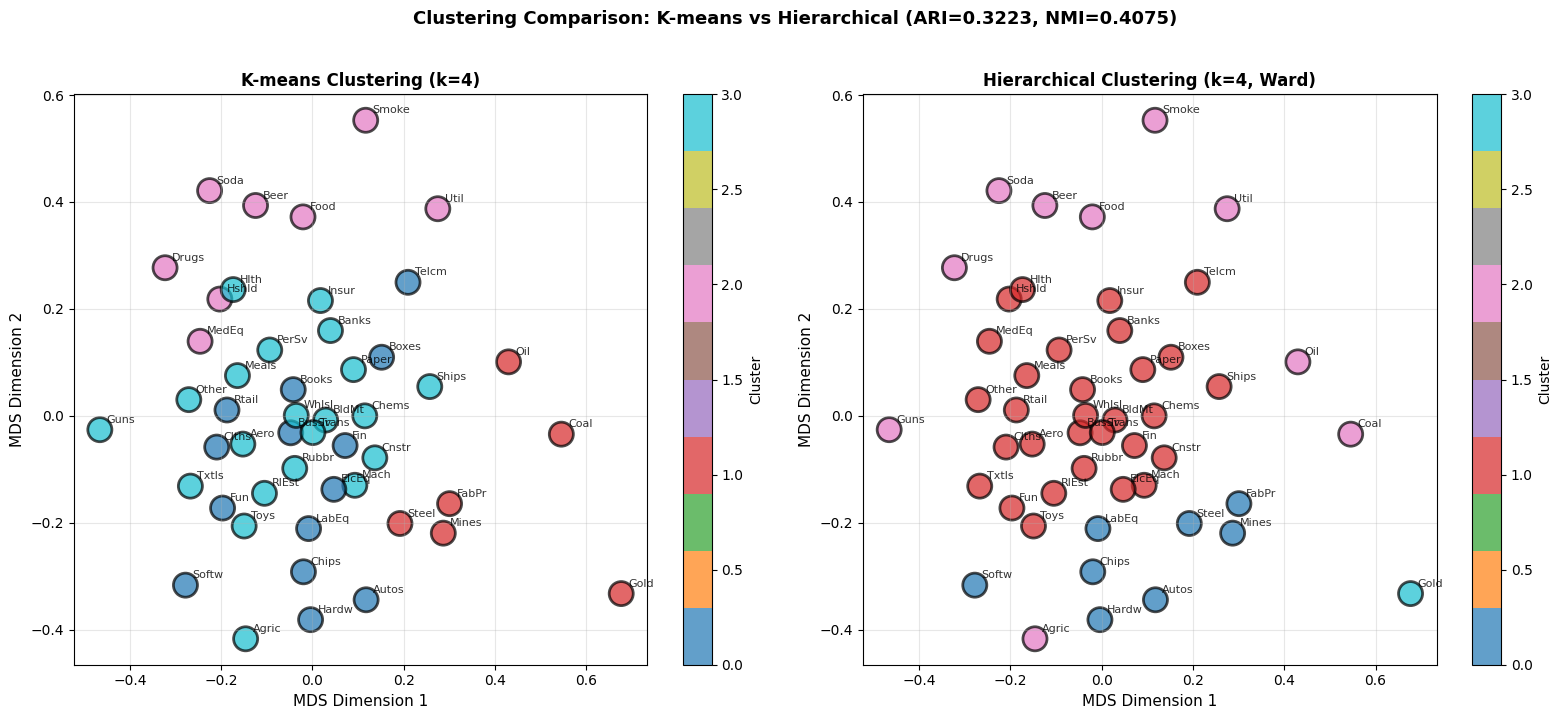

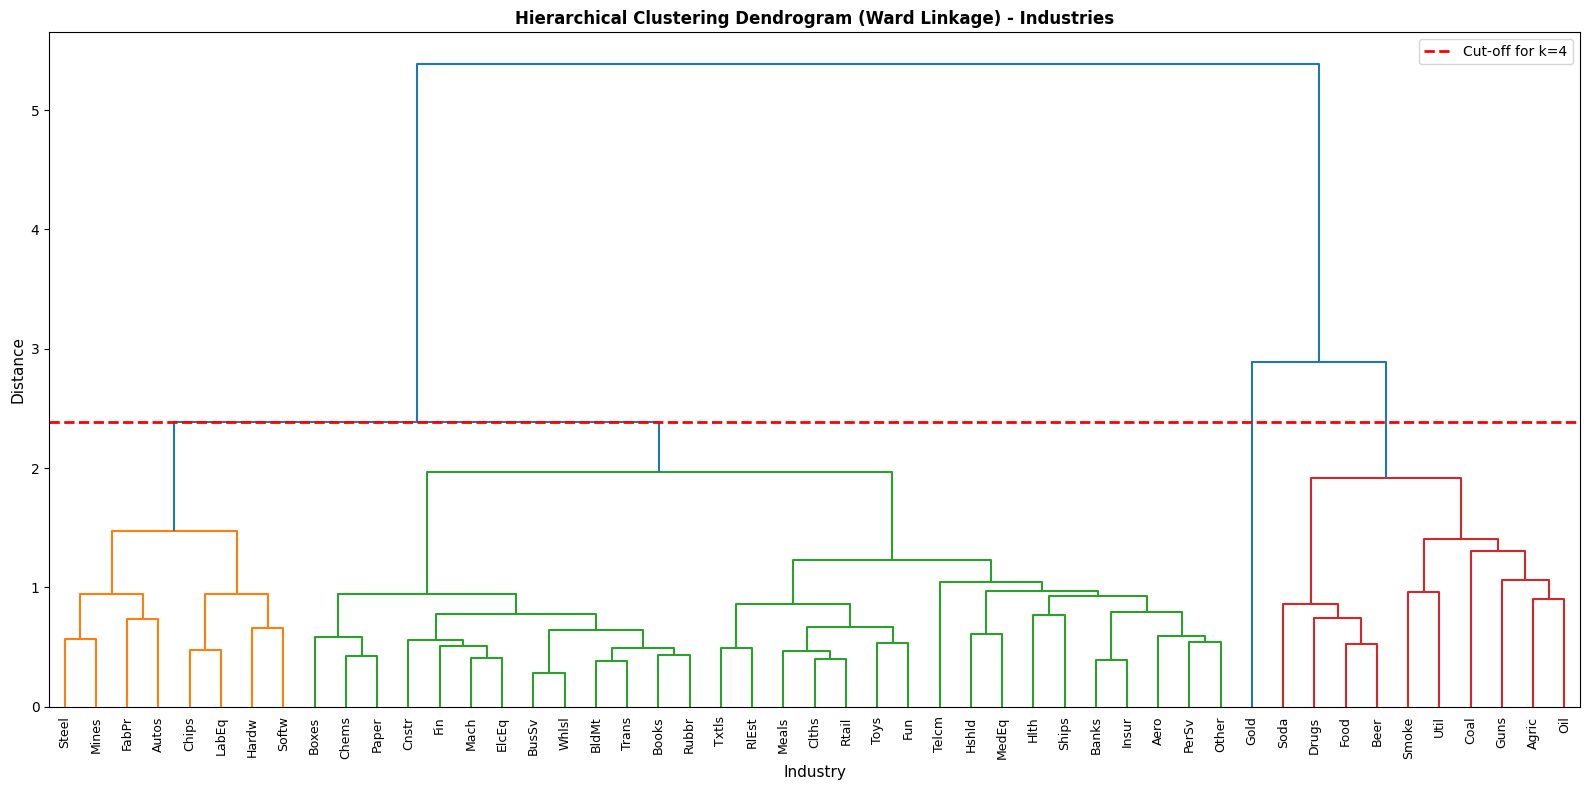


✓ Correlation-based Clustering Completed (K-means + Hierarchical)


In [20]:
# ===== Visualization of both methods =====
print("\n" + "-"*60)
print("Visualizations")
print("-"*60)

# Use MDS for visualization
from sklearn.manifold import MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_positions = mds.fit_transform(corr_distance)

# Create side-by-side comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# K-means plot
scatter1 = ax1.scatter(mds_positions[:, 0], mds_positions[:, 1], 
                       c=kmeans_labels, cmap='tab10', s=300, alpha=0.7, edgecolors='black', linewidth=2)
for j, txt in enumerate(industry_columns):
    ax1.annotate(txt, (mds_positions[j, 0], mds_positions[j, 1]), fontsize=8, alpha=0.8, 
                xytext=(5, 5), textcoords='offset points')
ax1.set_xlabel('MDS Dimension 1', fontsize=11)
ax1.set_ylabel('MDS Dimension 2', fontsize=11)
ax1.set_title(f'K-means Clustering (k={optimal_k_3a})', fontsize=12, fontweight='bold')
plt.colorbar(scatter1, ax=ax1, label='Cluster')
ax1.grid(True, alpha=0.3)

# Hierarchical plot
scatter2 = ax2.scatter(mds_positions[:, 0], mds_positions[:, 1], 
                       c=hierarchical_labels_corr, cmap='tab10', s=300, alpha=0.7, edgecolors='black', linewidth=2)
for j, txt in enumerate(industry_columns):
    ax2.annotate(txt, (mds_positions[j, 0], mds_positions[j, 1]), fontsize=8, alpha=0.8, 
                xytext=(5, 5), textcoords='offset points')
ax2.set_xlabel('MDS Dimension 1', fontsize=11)
ax2.set_ylabel('MDS Dimension 2', fontsize=11)
ax2.set_title(f'Hierarchical Clustering (k={optimal_k_3a}, Ward)', fontsize=12, fontweight='bold')
plt.colorbar(scatter2, ax=ax2, label='Cluster')
ax2.grid(True, alpha=0.3)

plt.suptitle(f'Clustering Comparison: K-means vs Hierarchical (ARI={ari_score:.4f}, NMI={nmi_score:.4f})', 
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Dendrogram for hierarchical clustering
fig, ax = plt.subplots(figsize=(16, 8))
dendrogram(linkage_matrix_corr, labels=industry_columns, leaf_font_size=9, 
           color_threshold=linkage_matrix_corr[-optimal_k_3a+1, 2], ax=ax)
ax.set_title('Hierarchical Clustering Dendrogram (Ward Linkage) - Industries', fontsize=12, fontweight='bold')
ax.set_xlabel('Industry', fontsize=11)
ax.set_ylabel('Distance', fontsize=11)
ax.axhline(y=linkage_matrix_corr[-optimal_k_3a+1, 2], color='red', linestyle='--', linewidth=2, label=f'Cut-off for k={optimal_k_3a}')
ax.legend()
plt.tight_layout()
plt.show()

print("\n✓ Correlation-based Clustering Completed (K-means + Hierarchical)")


### Step 3b: Alternative Clustering Method 1 - Based on Return Statistics

Clustering based on industry return statistics (mean return, volatility, Sharpe ratio, skewness) to provide an alternative perspective on industry groupings. This approach captures risk-return characteristics rather than co-movement patterns.

**Key Features:**
- Uses standardized return statistics as clustering features
- Captures risk-adjusted return profiles of industries
- Identifies industries with similar performance characteristics
- Complements correlation-based clustering with fundamental risk-return analysis


Step 3b: Alternative Clustering Method 1 - Return Statistics

Alternative Method 1: Based on Mean Return, Volatility, Sharpe Ratio, Skewness
------------------------------------------------------------

Return Statistics Summary:
       Mean_Return  Volatility  Excess_Return  Sharpe_Ratio   Skewness
count    49.000000   49.000000      49.000000     49.000000  49.000000
mean      1.012526    6.666820       1.010859      0.157225  -0.108805
std       0.162606    1.441878       0.162606      0.036092   0.278128
min       0.597366    4.126989       0.595699      0.091659  -0.517338
25%       0.914137    5.712019       0.912470      0.137383  -0.286481
50%       1.024196    6.446513       1.022530      0.164218  -0.190750
75%       1.090536    7.441264       1.088869      0.180255   0.042120
max       1.400640   11.178800       1.398973      0.224742   0.681135

Data Standardization (Step 3b):
  Mean of scaled data: 0.000000
  Std of scaled data: 1.010363

---------------------------------

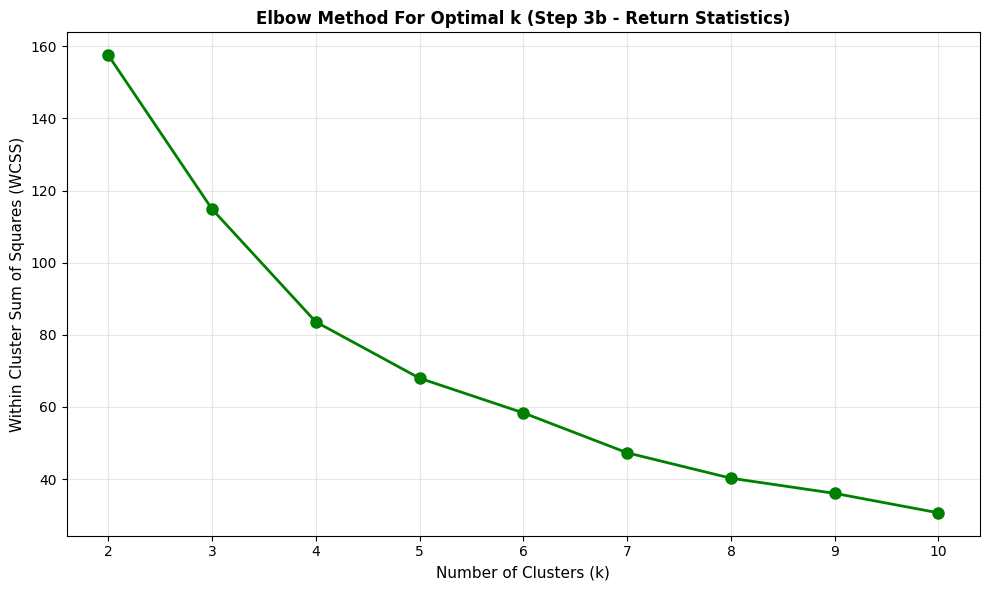


Elbow Method Analysis (Step 3b):
  Optimal k: 5
  WCSS at optimal k: 67.98

------------------------------------------------------------
K-means Clustering on Return Statistics (k=5)
------------------------------------------------------------

K-means Clustering (k=5)
Industries per cluster: [12  9 18  4  6]

Statistics-based Cluster Distribution:
Statistics_Cluster
0    12
1     9
2    18
3     4
4     6
Name: count, dtype: int64

Detailed Statistics-based Cluster Assignment:

Cluster 0 (12 industries):
Agric, Soda, Clths, BldMt, Cnstr, Mach, ElcEq, Ships, Mines, Oil, Hardw, LabEq
  Mean Return: 1.0661
  Mean Volatility: 6.8169
  Mean Sharpe Ratio: 0.1568
  Mean Skewness: -0.1152

Cluster 1 (9 industries):
Toys, Books, Hlth, Txtls, Steel, FabPr, PerSv, RlEst, Other
  Mean Return: 0.7903
  Mean Volatility: 7.3911
  Mean Sharpe Ratio: 0.1070
  Mean Skewness: -0.0466

Cluster 2 (18 industries):
Food, Beer, Hshld, MedEq, Drugs, Chems, Rubbr, Util, Telcm, BusSv, Paper, Boxes, Trans, Whls

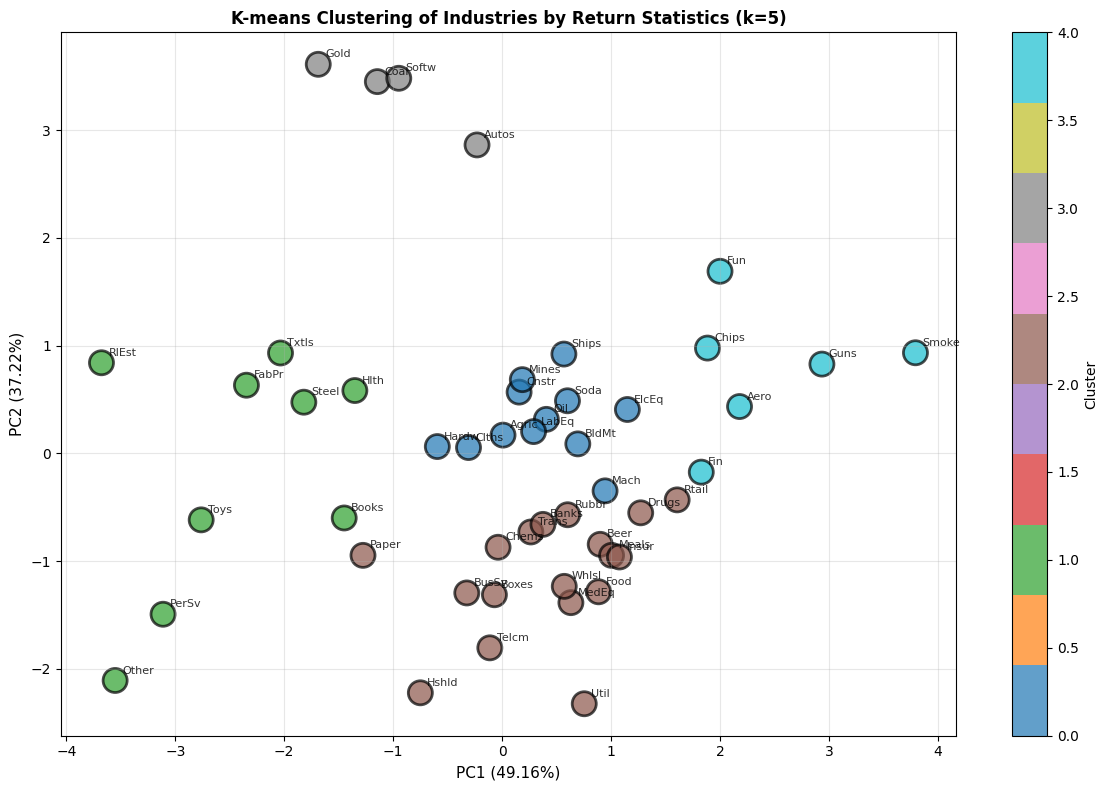


✓ Statistics-based Clustering Completed


In [21]:
# Step 3b: Alternative Method 1 - Clustering based on Return Statistics
print("\n" + "="*60)
print("Step 3b: Alternative Clustering Method 1 - Return Statistics")
print("="*60)
print("\nAlternative Method 1: Based on Mean Return, Volatility, Sharpe Ratio, Skewness")
print("-"*60)

# Prepare industry statistics for clustering
industry_stats = pd.DataFrame()

# Calculate statistics for each industry
rf_annual = 0.02
rf_monthly = rf_annual / 12

for industry in industry_columns:
    returns = returns_data_clean[industry]
    
    industry_stats.loc[industry, 'Mean_Return'] = returns.mean()
    industry_stats.loc[industry, 'Volatility'] = returns.std()
    industry_stats.loc[industry, 'Excess_Return'] = returns.mean() - rf_monthly
    industry_stats.loc[industry, 'Sharpe_Ratio'] = (returns.mean() - rf_monthly) / returns.std() if returns.std() > 0 else 0
    industry_stats.loc[industry, 'Skewness'] = returns.skew()

print(f"\nReturn Statistics Summary:")
print(industry_stats.describe())

# Standardize statistics for clustering BEFORE applying clustering methods
scaler_stats = StandardScaler()
stats_scaled = scaler_stats.fit_transform(industry_stats)
stats_scaled_df = pd.DataFrame(stats_scaled, columns=industry_stats.columns, index=industry_stats.index)

print(f"\nData Standardization (Step 3b):")
print(f"  Mean of scaled data: {stats_scaled_df.mean().mean():.6f}")
print(f"  Std of scaled data: {stats_scaled_df.std().mean():.6f}")

# ===== Elbow Method for Optimal K (Step 3b) =====
print("\n" + "-"*60)
print("Determining Optimal Number of Clusters using Elbow Method")
print("-"*60)

# Apply elbow method - compute WCSS for different k values
wcss_3b = []
k_range = range(2, min(11, len(industry_columns)))

for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(stats_scaled)
    wcss_3b.append(kmeans_temp.inertia_)

# Plot elbow curve
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(k_range, wcss_3b, 'go-', linewidth=2, markersize=8)
ax.set_xlabel('Number of Clusters (k)', fontsize=11)
ax.set_ylabel('Within Cluster Sum of Squares (WCSS)', fontsize=11)
ax.set_title('Elbow Method For Optimal k (Step 3b - Return Statistics)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find elbow point using the elbow method (second derivative)
if len(wcss_3b) >= 3:
    second_derivative = np.diff(wcss_3b, n=2)
    elbow_idx = np.argmax(second_derivative) + 2
    optimal_k_3b = list(k_range)[elbow_idx]
else:
    optimal_k_3b = list(k_range)[0]

print(f"\nElbow Method Analysis (Step 3b):")
print(f"  Optimal k: {optimal_k_3b}")
print(f"  WCSS at optimal k: {wcss_3b[optimal_k_3b - 2]:.2f}")

# Apply K-means clustering on return statistics with optimal k
print("\n" + "-"*60)
print(f"K-means Clustering on Return Statistics (k={optimal_k_3b})")
print("-"*60)

kmeans_stats = KMeans(n_clusters=optimal_k_3b, random_state=42, n_init=10)
kmeans_labels_stats = kmeans_stats.fit_predict(stats_scaled)

print(f"\nK-means Clustering (k={optimal_k_3b})")
print(f"Industries per cluster: {np.bincount(kmeans_labels_stats)}")

# Create cluster assignment for industries based on statistics
industry_clusters_stats = pd.DataFrame({
    'Industry': industry_columns,
    'Statistics_Cluster': kmeans_labels_stats
})

# Count industries per cluster
cluster_counts_stats = industry_clusters_stats['Statistics_Cluster'].value_counts().sort_index()
print(f"\nStatistics-based Cluster Distribution:")
print(cluster_counts_stats)

# Display industries in each cluster
print(f"\nDetailed Statistics-based Cluster Assignment:")
for cluster_id in range(optimal_k_3b):
    industries_in_cluster = industry_clusters_stats[
        industry_clusters_stats['Statistics_Cluster'] == cluster_id
    ]['Industry'].tolist()
    print(f"\nCluster {cluster_id} ({len(industries_in_cluster)} industries):")
    print(", ".join(industries_in_cluster))
    
    # Show cluster statistics
    cluster_industries_stats = industry_stats.loc[industries_in_cluster]
    print(f"  Mean Return: {cluster_industries_stats['Mean_Return'].mean():.4f}")
    print(f"  Mean Volatility: {cluster_industries_stats['Volatility'].mean():.4f}")
    print(f"  Mean Sharpe Ratio: {cluster_industries_stats['Sharpe_Ratio'].mean():.4f}")
    print(f"  Mean Skewness: {cluster_industries_stats['Skewness'].mean():.4f}")

# Visualize clusters using first two principal components of statistics
pca_stats = PCA(n_components=2)
stats_pca_positions = pca_stats.fit_transform(stats_scaled)

fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(stats_pca_positions[:, 0], stats_pca_positions[:, 1], 
                     c=kmeans_labels_stats, cmap='tab10', s=300, alpha=0.7, edgecolors='black', linewidth=2)

# Annotate industry names
for j, txt in enumerate(industry_columns):
    ax.annotate(txt, (stats_pca_positions[j, 0], stats_pca_positions[j, 1]), fontsize=8, alpha=0.8, 
                xytext=(5, 5), textcoords='offset points')

ax.set_xlabel(f'PC1 ({pca_stats.explained_variance_ratio_[0]:.2%})', fontsize=11)
ax.set_ylabel(f'PC2 ({pca_stats.explained_variance_ratio_[1]:.2%})', fontsize=11)
ax.set_title(f'K-means Clustering of Industries by Return Statistics (k={optimal_k_3b})', fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax, label='Cluster')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Statistics-based Clustering Completed")


### Step 3c: Alternative Clustering Method 2 - Based on Factor Exposures

Clustering based on industries' factor exposures (market beta, size factor loading, value factor loading) from the Fama-French 3-factor model. This approach groups industries by their systematic risk exposures.

**Key Features:**
- Uses Fama-French factor loadings (Beta, SMB, HML) as clustering features
- Captures systematic risk exposure patterns
- Identifies industries with similar factor sensitivities
- Provides economically meaningful clusters based on asset pricing factors


Step 3c: Alternative Clustering Method 2 - Factor Exposures

Alternative Method 2: Based on Market Beta, SMB Loading, HML Loading
------------------------------------------------------------

Merged data for factor analysis: (426, 56)

Factor Exposures Summary (Beta to Mkt, SMB, HML):
       Market_Beta   SMB_Beta   HML_Beta
count    49.000000  49.000000  49.000000
mean      0.952416   0.162063  -0.027058
std       0.270914   0.394488   0.432965
min       0.441879  -0.477783  -1.298710
25%       0.803391  -0.149707  -0.194102
50%       0.994557   0.126388   0.053724
75%       1.184714   0.415513   0.237016
max       1.524119   1.055370   0.661855

Data Standardization (Step 3c):
  Mean of scaled data: -0.000000
  Std of scaled data: 1.010363

------------------------------------------------------------
Determining Optimal Number of Clusters using Elbow Method
------------------------------------------------------------


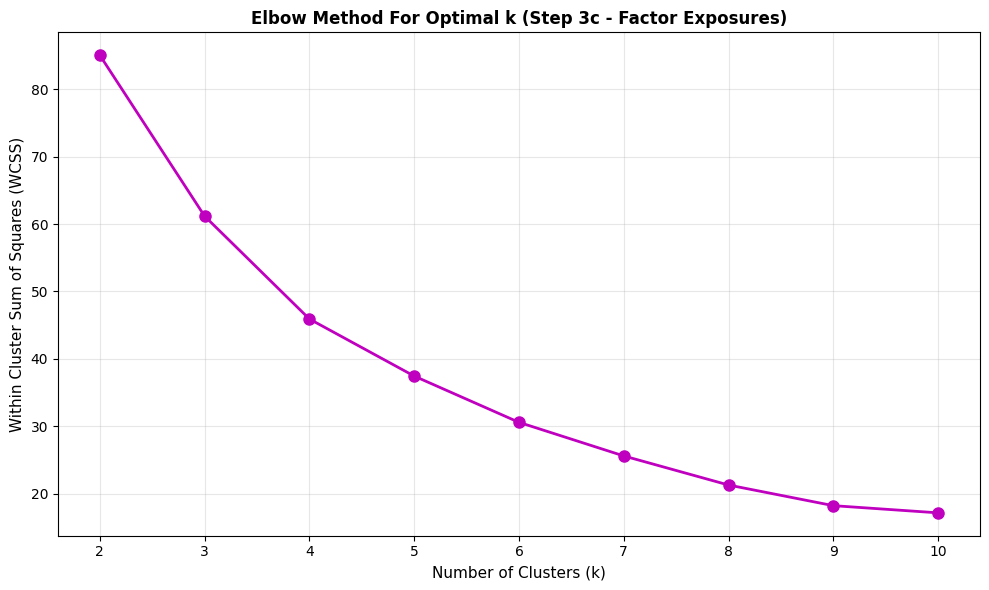


Elbow Method Analysis (Step 3c):
  Optimal k: 4
  WCSS at optimal k: 45.92

------------------------------------------------------------
K-means Clustering on Factor Exposures (k=4)
------------------------------------------------------------

K-means Clustering (k=4)
Industries per cluster: [ 8 22 10  9]

Factor Exposure-based Cluster Distribution:
Factor_Cluster
0     8
1    22
2    10
3     9
Name: count, dtype: int64

Detailed Factor Exposure-based Cluster Assignment:

Cluster 0 (8 industries):
Fun, ElcEq, Autos, BusSv, Hardw, Softw, Chips, LabEq
  Mean Market Beta: 1.2107
  Mean SMB Beta: 0.3328
  Mean HML Beta: -0.7622

Cluster 1 (22 industries):
Agric, Books, Clths, Hlth, MedEq, Chems, Rubbr, BldMt, Aero, Ships, Oil, Telcm, PerSv, Paper, Boxes, Trans, Whlsl, Rtail, Meals, Banks, Fin, Other
  Mean Market Beta: 0.9244
  Mean SMB Beta: 0.0408
  Mean HML Beta: 0.0815

Cluster 2 (10 industries):
Toys, Txtls, Cnstr, Steel, FabPr, Mach, Gold, Mines, Coal, RlEst
  Mean Market Beta: 1.1

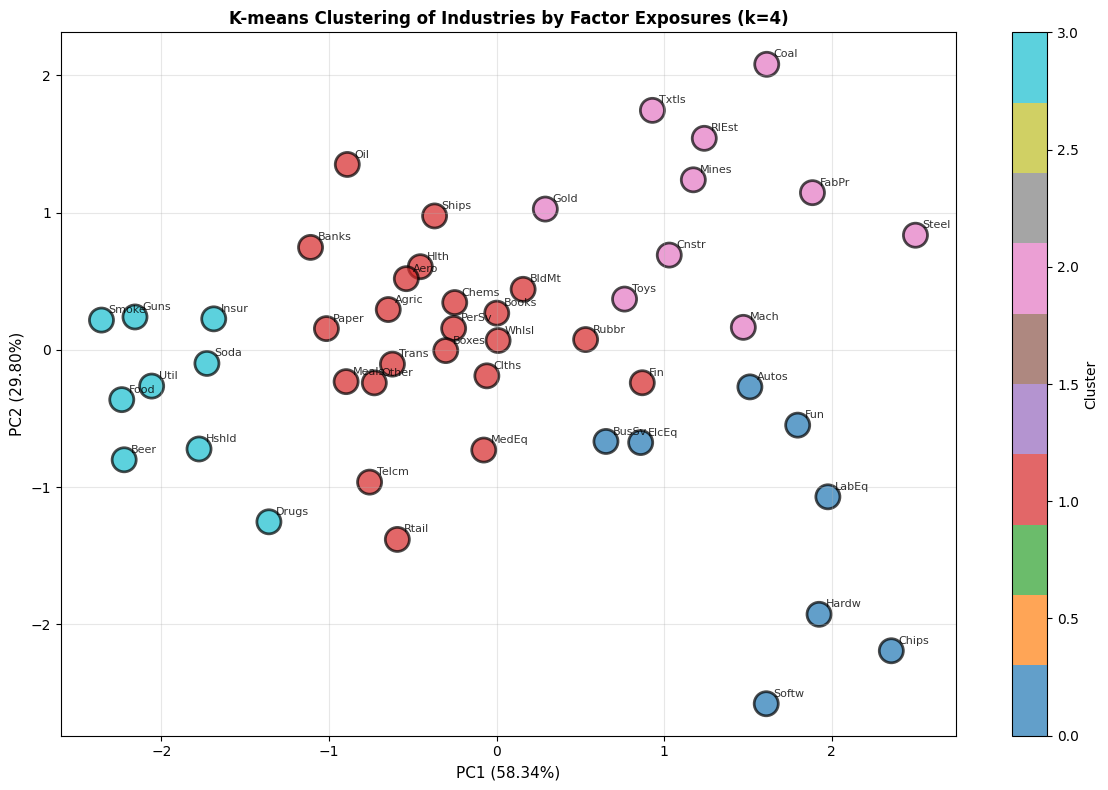


✓ Factor Exposure-based Clustering Completed


In [22]:
# Step 3c: Alternative Method 2 - Clustering based on Factor Exposures
print("\n" + "="*60)
print("Step 3c: Alternative Clustering Method 2 - Factor Exposures")
print("="*60)
print("\nAlternative Method 2: Based on Market Beta, SMB Loading, HML Loading")
print("-"*60)

# Define factor columns
factor_cols = ['Mkt-RF', 'SMB', 'HML', 'RF']

# Prepare Fama-French factor data for factor exposure calculation
df_industry_clean['YearMonth'] = pd.to_datetime(df_industry_clean['Date'], format='%Y%m')
df_Fama['YearMonth'] = pd.to_datetime(df_Fama['Date'], format='%Y%m')

# Merge industry returns with Fama-French factors
merged_data_factor = pd.merge(df_industry_clean, df_Fama, on='YearMonth', how='inner')

# Convert columns to numeric
for col in industry_columns:
    if col in merged_data_factor.columns:
        merged_data_factor[col] = pd.to_numeric(merged_data_factor[col], errors='coerce')

for col in factor_cols:
    if col in merged_data_factor.columns:
        merged_data_factor[col] = pd.to_numeric(merged_data_factor[col], errors='coerce')

# Remove rows with missing values
merged_data_factor_clean = merged_data_factor.dropna(subset=factor_cols + industry_columns)

print(f"\nMerged data for factor analysis: {merged_data_factor_clean.shape}")

# Calculate factor exposures (betas) for each industry
from scipy import stats as sp_stats

factor_exposures = []
for industry in industry_columns:
    if industry in merged_data_factor_clean.columns:
        industry_excess_return = merged_data_factor_clean[industry] - merged_data_factor_clean['RF']
        
        # Market Beta
        slope_mkt, _, _, _, _ = sp_stats.linregress(merged_data_factor_clean['Mkt-RF'], industry_excess_return)
        
        # SMB Beta (Size factor)
        slope_smb, _, _, _, _ = sp_stats.linregress(merged_data_factor_clean['SMB'], industry_excess_return)
        
        # HML Beta (Value factor)
        slope_hml, _, _, _, _ = sp_stats.linregress(merged_data_factor_clean['HML'], industry_excess_return)
        
        factor_exposures.append({
            'Industry': industry,
            'Market_Beta': slope_mkt,
            'SMB_Beta': slope_smb,
            'HML_Beta': slope_hml
        })

factor_exposures_df = pd.DataFrame(factor_exposures)
factor_exposures_df.set_index('Industry', inplace=True)

print(f"\nFactor Exposures Summary (Beta to Mkt, SMB, HML):")
print(factor_exposures_df.describe())

# Standardize factor exposures for clustering BEFORE applying clustering methods
scaler_factors = StandardScaler()
factors_scaled = scaler_factors.fit_transform(factor_exposures_df)
factors_scaled_df = pd.DataFrame(factors_scaled, columns=factor_exposures_df.columns, index=factor_exposures_df.index)

print(f"\nData Standardization (Step 3c):")
print(f"  Mean of scaled data: {factors_scaled_df.mean().mean():.6f}")
print(f"  Std of scaled data: {factors_scaled_df.std().mean():.6f}")

# ===== Elbow Method for Optimal K (Step 3c) =====
print("\n" + "-"*60)
print("Determining Optimal Number of Clusters using Elbow Method")
print("-"*60)

# Apply elbow method - compute WCSS for different k values
wcss_3c = []
k_range = range(2, min(11, len(industry_columns)))

for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(factors_scaled)
    wcss_3c.append(kmeans_temp.inertia_)

# Plot elbow curve
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(k_range, wcss_3c, 'mo-', linewidth=2, markersize=8)
ax.set_xlabel('Number of Clusters (k)', fontsize=11)
ax.set_ylabel('Within Cluster Sum of Squares (WCSS)', fontsize=11)
ax.set_title('Elbow Method For Optimal k (Step 3c - Factor Exposures)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find elbow point using the elbow method (second derivative)
if len(wcss_3c) >= 3:
    second_derivative = np.diff(wcss_3c, n=2)
    elbow_idx = np.argmax(second_derivative) + 2
    optimal_k_3c = list(k_range)[elbow_idx]
else:
    optimal_k_3c = list(k_range)[0]

print(f"\nElbow Method Analysis (Step 3c):")
print(f"  Optimal k: {optimal_k_3c}")
print(f"  WCSS at optimal k: {wcss_3c[optimal_k_3c - 2]:.2f}")

# Apply K-means clustering on factor exposures with optimal k
print("\n" + "-"*60)
print(f"K-means Clustering on Factor Exposures (k={optimal_k_3c})")
print("-"*60)

kmeans_factors = KMeans(n_clusters=optimal_k_3c, random_state=42, n_init=10)
kmeans_labels_factors = kmeans_factors.fit_predict(factors_scaled)

print(f"\nK-means Clustering (k={optimal_k_3c})")
print(f"Industries per cluster: {np.bincount(kmeans_labels_factors)}")

# Create cluster assignment for industries based on factor exposures
industry_clusters_factors = pd.DataFrame({
    'Industry': industry_columns,
    'Factor_Cluster': kmeans_labels_factors
})

# Count industries per cluster
cluster_counts_factors = industry_clusters_factors['Factor_Cluster'].value_counts().sort_index()
print(f"\nFactor Exposure-based Cluster Distribution:")
print(cluster_counts_factors)

# Display industries in each cluster
print(f"\nDetailed Factor Exposure-based Cluster Assignment:")
for cluster_id in range(optimal_k_3c):
    industries_in_cluster = industry_clusters_factors[
        industry_clusters_factors['Factor_Cluster'] == cluster_id
    ]['Industry'].tolist()
    print(f"\nCluster {cluster_id} ({len(industries_in_cluster)} industries):")
    print(", ".join(industries_in_cluster))
    
    # Show cluster factor exposures
    cluster_exposures = factor_exposures_df.loc[industries_in_cluster]
    print(f"  Mean Market Beta: {cluster_exposures['Market_Beta'].mean():.4f}")
    print(f"  Mean SMB Beta: {cluster_exposures['SMB_Beta'].mean():.4f}")
    print(f"  Mean HML Beta: {cluster_exposures['HML_Beta'].mean():.4f}")

# Visualize clusters using first two principal components of factor exposures
pca_factors = PCA(n_components=2)
factors_pca_positions = pca_factors.fit_transform(factors_scaled)

fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(factors_pca_positions[:, 0], factors_pca_positions[:, 1], 
                     c=kmeans_labels_factors, cmap='tab10', s=300, alpha=0.7, edgecolors='black', linewidth=2)

# Annotate industry names
for j, txt in enumerate(industry_columns):
    ax.annotate(txt, (factors_pca_positions[j, 0], factors_pca_positions[j, 1]), fontsize=8, alpha=0.8, 
                xytext=(5, 5), textcoords='offset points')

ax.set_xlabel(f'PC1 ({pca_factors.explained_variance_ratio_[0]:.2%})', fontsize=11)
ax.set_ylabel(f'PC2 ({pca_factors.explained_variance_ratio_[1]:.2%})', fontsize=11)
ax.set_title(f'K-means Clustering of Industries by Factor Exposures (k={optimal_k_3c})', fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax, label='Cluster')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Factor Exposure-based Clustering Completed")


## Step 4: Interpret Clusters - Economic Interpretation

Analyze the characteristics and relationships within and between clusters to provide economic meaning to the discovered industry groupings. This includes examining return statistics, volatility patterns, and correlation structures.

---

## Additional Analysis: Factor Exposures

Analyze factor loadings (Beta, SMB, HML) for each industry using Fama-French 3-factor model. This reveals how clusters differ in their exposure to market risk, size, and value factors.

In [23]:
# Step 4: Economic Interpretation of Clusters
print("\n" + "="*60)
print("Step 4: Economic Interpretation of Clusters (Based on Step 3a)")
print("="*60)

# Calculate risk-free rate (approximate annual rate)
rf_annual = 0.02  # 2% annual risk-free rate

# Analyze cluster characteristics using original returns
returns_by_cluster = []
for cluster_id in range(optimal_k_3a):
    industries_mask = kmeans_labels == cluster_id
    cluster_industries = np.array(industry_columns)[industries_mask]
    cluster_returns = returns_data_clean[cluster_industries]
    
    # Cluster-level statistics
    avg_return = cluster_returns.mean().mean()
    volatility = cluster_returns.std().mean()
    skewness = cluster_returns.skew().mean()
    
    # Calculate Sharpe ratio (monthly risk-free rate = annual / 12)
    rf_monthly = rf_annual / 12
    excess_returns = cluster_returns.mean() - rf_monthly
    sharpe_ratio = (excess_returns.mean() / cluster_returns.std().mean()) if cluster_returns.std().mean() > 0 else 0
    
    returns_by_cluster.append({
        'Cluster': cluster_id,
        'Avg_Return': avg_return,
        'Volatility': volatility,
        'Skewness': skewness,
        'Sharpe_Ratio': sharpe_ratio,
        'Num_Industries': len(cluster_industries)
    })

cluster_stats = pd.DataFrame(returns_by_cluster)
print("\n" + "="*60)
print("1. RISK-RETURN PROFILE (Mean return, Volatility, Sharpe, Skewness)")
print("="*60)
print(cluster_stats.to_string(index=False))

# Detailed pairwise correlations within each cluster
print("\n\n" + "="*60)
print("2. RETURN CORRELATIONS (Pairwise Correlations of Industry Returns)")
print("="*60)

print("\nWithin-cluster Pairwise Correlations:")
for cluster_id in range(optimal_k_3a):
    industries_mask = kmeans_labels == cluster_id
    cluster_industries = np.array(industry_columns)[industries_mask]
    industries_list = cluster_industries.tolist()
    
    if len(cluster_industries) > 1:
        cluster_corr = returns_data_clean[industries_list].corr()
        print(f"\nCluster {cluster_id} ({len(industries_list)} industries):")
        print(f"  {', '.join(industries_list)}")
        
        # Get average absolute correlation (excluding diagonal)
        corr_values = cluster_corr.values[np.triu_indices_from(cluster_corr.values, k=1)]
        avg_corr = corr_values.mean()
        min_corr = corr_values.min()
        max_corr = corr_values.max()
        
        print(f"  Average correlation: {avg_corr:.3f}")
        print(f"  Min correlation: {min_corr:.3f}, Max correlation: {max_corr:.3f}")

# Pairwise correlations between clusters
print("\n\nBetween-cluster Pairwise Correlations:")
for i in range(optimal_k_3a):
    for j in range(i+1, optimal_k_3a):
        industries_i = np.array(industry_columns)[kmeans_labels == i]
        industries_j = np.array(industry_columns)[kmeans_labels == j]
        
        # Compute pairwise correlations between all industries in cluster i vs j
        corr_matrix = returns_data_clean[industries_i.tolist()].corrwith(
            returns_data_clean[industries_j.tolist()].mean(axis=1)
        )
        between_corr = corr_matrix.mean()
        
        print(f"Cluster {i} (n={len(industries_i)}) vs Cluster {j} (n={len(industries_j)}): {between_corr:.3f}")



Step 4: Economic Interpretation of Clusters (Based on Step 3a)

1. RISK-RETURN PROFILE (Mean return, Volatility, Sharpe, Skewness)
 Cluster  Avg_Return  Volatility  Skewness  Sharpe_Ratio  Num_Industries
       0    1.062621    6.808958 -0.098957      0.155817              14
       1    1.006644    8.702537  0.075352      0.115481               6
       2    1.031298    5.155203 -0.074516      0.199727               8
       3    0.973657    6.566283 -0.181050      0.148028              21


2. RETURN CORRELATIONS (Pairwise Correlations of Industry Returns)

Within-cluster Pairwise Correlations:

Cluster 0 (14 industries):
  Fun, Books, Clths, ElcEq, Autos, Telcm, BusSv, Hardw, Softw, Chips, LabEq, Boxes, Rtail, Fin
  Average correlation: 0.657
  Min correlation: 0.450, Max correlation: 0.819

Cluster 1 (6 industries):
  Steel, FabPr, Gold, Mines, Coal, Oil
  Average correlation: 0.495
  Min correlation: 0.203, Max correlation: 0.776

Cluster 2 (8 industries):
  Food, Soda, Beer, Smo

In [24]:
# ===== GICS Sector Classification (11 One-Level Sectors) =====
print("\n" + "="*60)
print("GICS Sector Classification")
print("="*60)

def assign_gics_sector(industry_name):
    """
    Assign GICS sector based on 49 Fama-French industry classifications.
    Mapping based on standard GICS Level 1 (Sector) classification.
    11 GICS Sectors:
    - Energy, Materials, Industrials, Consumer Discretionary
    - Consumer Staples, Health Care, Financials
    - Information Technology, Communication Services, Utilities, Real Estate
    """
    industry_to_gics = {
        'Coal': 'Energy', 'Oil': 'Energy',
        'Chems': 'Materials', 'Rubbr': 'Materials', 'BldMt': 'Materials',
        'Steel': 'Materials', 'Gold': 'Materials', 'Mines': 'Materials',
        'Paper': 'Materials', 'Boxes': 'Materials',
        'Cnstr': 'Industrials', 'Aero': 'Industrials', 'Ships': 'Industrials',
        'Guns': 'Industrials', 'ElcEq': 'Industrials', 'Mach': 'Industrials',
        'FabPr': 'Industrials', 'Trans': 'Industrials', 'LabEq': 'Industrials',
        'Autos': 'Consumer Discretionary', 'Clths': 'Consumer Discretionary',
        'Toys': 'Consumer Discretionary', 'Fun': 'Consumer Discretionary',
        'Books': 'Consumer Discretionary', 'PerSv': 'Consumer Discretionary',
        'Whlsl': 'Consumer Discretionary', 'Rtail': 'Consumer Discretionary',
        'Meals': 'Consumer Discretionary', 'Txtls': 'Consumer Discretionary',
        'Food': 'Consumer Staples', 'Soda': 'Consumer Staples',
        'Beer': 'Consumer Staples', 'Smoke': 'Consumer Staples',
        'Hshld': 'Consumer Staples', 'Agric': 'Consumer Staples',
        'Hlth': 'Health Care', 'MedEq': 'Health Care', 'Drugs': 'Health Care',
        'Banks': 'Financials', 'Insur': 'Financials', 'Fin': 'Financials',
        'Hardw': 'Information Technology', 'Softw': 'Information Technology',
        'Chips': 'Information Technology', 'BusSv': 'Information Technology',
        'Telcm': 'Communication Services',
        'Util': 'Utilities',
        'RlEst': 'Real Estate',
        'Other': 'Other'
    }
    return industry_to_gics.get(industry_name, 'Other')

# Create GICS sector assignment
gics_assignment = pd.DataFrame({
    'Industry': industry_columns,
    'GICS_Sector': [assign_gics_sector(ind) for ind in industry_columns]
})

print("\nGICS Distribution across all 49 industries:")
print("-"*60)
gics_counts = gics_assignment['GICS_Sector'].value_counts().sort_index()
for sector in sorted(gics_assignment['GICS_Sector'].unique()):
    if sector != 'Other':
        industries = gics_assignment[gics_assignment['GICS_Sector'] == sector]['Industry'].tolist()
        print(f"\n{sector}: {len(industries)} industries")
        print(f"  {', '.join(industries)}")

print(f"\n" + "-"*60)
print(f"Total GICS Sectors: {len(gics_counts)}")
print(f"Total Industries Classified: {gics_counts.sum()}")


GICS Sector Classification

GICS Distribution across all 49 industries:
------------------------------------------------------------

Communication Services: 1 industries
  Telcm

Consumer Discretionary: 10 industries
  Toys, Fun, Books, Clths, Txtls, Autos, PerSv, Whlsl, Rtail, Meals

Consumer Staples: 6 industries
  Agric, Food, Soda, Beer, Smoke, Hshld

Energy: 2 industries
  Coal, Oil

Financials: 3 industries
  Banks, Insur, Fin

Health Care: 3 industries
  Hlth, MedEq, Drugs

Industrials: 9 industries
  Cnstr, FabPr, Mach, ElcEq, Aero, Ships, Guns, LabEq, Trans

Information Technology: 4 industries
  BusSv, Hardw, Softw, Chips

Materials: 8 industries
  Chems, Rubbr, BldMt, Steel, Gold, Mines, Paper, Boxes

Real Estate: 1 industries
  RlEst

Utilities: 1 industries
  Util

------------------------------------------------------------
Total GICS Sectors: 12
Total Industries Classified: 49


In [25]:
# Step 4: Sankey Diagram - GICS Sectors to Industries (colored by K-means Clusters)
print("\n" + "="*60)
print("Step 4: Sankey Diagram - GICS to Industries with Cluster Coloring")
print("="*60)

import plotly.graph_objects as go
import numpy as np

# Create mapping of industries to clusters
industry_to_cluster = dict(zip(industry_columns, kmeans_labels))

# Create the GICS sector to industry mapping
sectors_list = sorted(gics_assignment['GICS_Sector'].unique())
sectors_list = [s for s in sectors_list if s != 'Other']  # Exclude 'Other' for clarity

# Build data for Sankey diagram
source_indices = []  # GICS sector indices
target_indices = []  # Industry indices
values = []          # Flow values (all 1 for single connection)
link_colors = []     # Colors based on K-means clusters

# Create node labels and indices
node_labels = []
node_colors = []

# Add GICS sectors as source nodes
gics_node_start = 0
gics_node_indices = {}
for i, sector in enumerate(sectors_list):
    node_labels.append(sector)
    gics_node_indices[sector] = i
    node_colors.append('lightgray')

# Add industries as target nodes (sorted by cluster for better visualization)
# Sort industries by cluster ID so same-cluster industries are grouped together
industries_sorted_by_cluster = sorted(industry_columns, key=lambda x: industry_to_cluster[x])

industry_node_start = len(sectors_list)
industry_node_indices = {}

# Define color palette for clusters
cluster_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                  '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

color_map = {i: cluster_colors[i % len(cluster_colors)] for i in range(optimal_k_3a)}

for i, industry in enumerate(industries_sorted_by_cluster):
    node_labels.append(industry)
    industry_node_indices[industry] = industry_node_start + i
    cluster_id = industry_to_cluster[industry]
    node_colors.append(color_map[cluster_id])

# Create connections from GICS sectors to industries
for industry in industry_columns:
    gics_sector = assign_gics_sector(industry)
    cluster_id = industry_to_cluster[industry]
    
    if gics_sector in gics_node_indices:
        source_indices.append(gics_node_indices[gics_sector])
        target_indices.append(industry_node_indices[industry])
        values.append(1)
        # Use semi-transparent version of cluster color for links
        link_color = color_map[cluster_id]
        # Convert to RGBA with transparency
        if link_color.startswith('#'):
            r = int(link_color[1:3], 16)
            g = int(link_color[3:5], 16)
            b = int(link_color[5:7], 16)
            link_colors.append(f'rgba({r},{g},{b},0.4)')
        else:
            link_colors.append('rgba(200,200,200,0.4)')

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=25,
        line=dict(color='black', width=0.5),
        label=node_labels,
        color=node_colors,
        x=[0.1] * len(sectors_list) + [0.9] * len(industry_columns),  # Position GICS on left, industries on right
        y=np.linspace(0, 1, len(sectors_list)).tolist() + np.linspace(0, 1, len(industry_columns)).tolist()
    ),
    link=dict(
        source=source_indices,
        target=target_indices,
        value=values,
        color=link_colors
    )
)])

fig.update_layout(
    title={
        'text': 'GICS Sectors to Industries Mapping (colored by K-means Clusters)',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 16}
    },
    font=dict(size=10),
    height=800,
    width=1400,
    margin=dict(l=50, r=50, t=100, b=50)
)


fig.show()
print("✓ Sankey diagram created successfully")
print(f"\nLegend:")
for cluster_id in range(optimal_k_3a):
    cluster_count = np.sum(kmeans_labels == cluster_id)
    print(f"  Cluster {cluster_id}: {cluster_count} industries - {color_map[cluster_id]}")



Step 4: Sankey Diagram - GICS to Industries with Cluster Coloring


✓ Sankey diagram created successfully

Legend:
  Cluster 0: 14 industries - #1f77b4
  Cluster 1: 6 industries - #ff7f0e
  Cluster 2: 8 industries - #2ca02c
  Cluster 3: 21 industries - #d62728


In [26]:
# Step 5b: Animation - Cluster Distribution Evolution Over Time
print("\n" + "="*60)
print("Step 5b: Cluster Evolution Animation (MDS + Rolling Window)")
print("="*60)

import imageio
import io
from PIL import Image

# Sliding window: 10 years (120 months) with 10-year steps
window_size = 120  # 10 years
step_size = 120    # 10-year steps
n_windows = (len(returns_data_clean) - window_size) // step_size + 1

print(f"\nCreating animation with {n_windows} windows:")
print(f"  Window size: {window_size} months (10 years)")
print(f"  Step size: {step_size} months (10-year intervals)")

# Store clustering results for each time window
sliding_window_data = []

for win_idx in range(n_windows):
    start_idx = win_idx * step_size
    end_idx = start_idx + window_size
    
    if end_idx > len(returns_data_clean):
        break
    
    window_returns = returns_data_clean.iloc[start_idx:end_idx]
    window_date_start = df_industry_clean.iloc[start_idx]['Date']
    window_date_end = df_industry_clean.iloc[end_idx-1]['Date']
    
    # Cluster based on correlation distance (49 industries)
    window_corr_matrix = window_returns.corr()
    window_corr_distance = 1 - np.abs(window_corr_matrix.values)
    
    kmeans_corr = KMeans(n_clusters=optimal_k_3a, random_state=42, n_init=10)
    window_cluster_labels = kmeans_corr.fit_predict(window_corr_distance)
    
    # Get 2D positions for 49 industries using MDS on correlation distance
    mds_corr = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    industry_positions = mds_corr.fit_transform(window_corr_distance)
    
    sliding_window_data.append({
        'window_idx': win_idx + 1,
        'date_start': window_date_start,
        'date_end': window_date_end,
        'industry_positions': industry_positions,
        'cluster_labels': window_cluster_labels
    })

print(f"Processed {len(sliding_window_data)} time windows")

# Generate frames for animation
print("\nGenerating frames...")
frames = []

for frame_idx in range(len(sliding_window_data)):
    data = sliding_window_data[frame_idx]
    positions = data['industry_positions']
    labels = data['cluster_labels']
    date_range = f"{int(data['date_start'])} to {int(data['date_end'])}"
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Scatter plot with color-coded clusters
    scatter = ax.scatter(positions[:, 0], positions[:, 1], 
                        c=labels, cmap='tab10', s=300, alpha=0.7, 
                        edgecolors='black', linewidth=2, vmin=0, vmax=optimal_k_3a-1)
    
    # Annotate industry names
    for j, txt in enumerate(industry_columns):
        ax.annotate(txt, (positions[j, 0], positions[j, 1]), fontsize=9, alpha=0.8,
                   xytext=(5, 5), textcoords='offset points')
    
    ax.set_xlabel('MDS1', fontsize=11)
    ax.set_ylabel('MDS2', fontsize=11)
    ax.set_title(f'Industry Clustering: {date_range}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Cluster')
    
    # Save frame to bytes
    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
    buf.seek(0)
    
    # Read frame as image
    frame = np.array(Image.open(buf))
    frames.append(frame)
    
    plt.close(fig)
    print(f"  Frame {frame_idx+1}/{len(sliding_window_data)} generated")

# Save as GIF using imageio
output_path = 'cluster_evolution.gif'
print(f"\nSaving animation to {output_path}...")
try:
    # Duration unit: seconds. Set fps=1 to ensure animation plays at 1 frame per second (2 seconds per frame)
    imageio.mimsave(output_path, frames, fps=1, loop=0)
    print(f"✓ Animation saved successfully as {output_path}")
    print(f"  Total frames: {len(frames)}")
    print(f"  Duration per frame: 2.0 seconds")
except Exception as e:
    print(f"Error: {e}")

print("\n✓ Animation complete")


Step 5b: Cluster Evolution Animation (MDS + Rolling Window)

Creating animation with 5 windows:
  Window size: 120 months (10 years)
  Step size: 120 months (10-year intervals)
Processed 5 time windows

Generating frames...
  Frame 1/5 generated
  Frame 2/5 generated
  Frame 3/5 generated
  Frame 4/5 generated
  Frame 5/5 generated

Saving animation to cluster_evolution.gif...
✓ Animation saved successfully as cluster_evolution.gif
  Total frames: 5
  Duration per frame: 2.0 seconds

✓ Animation complete


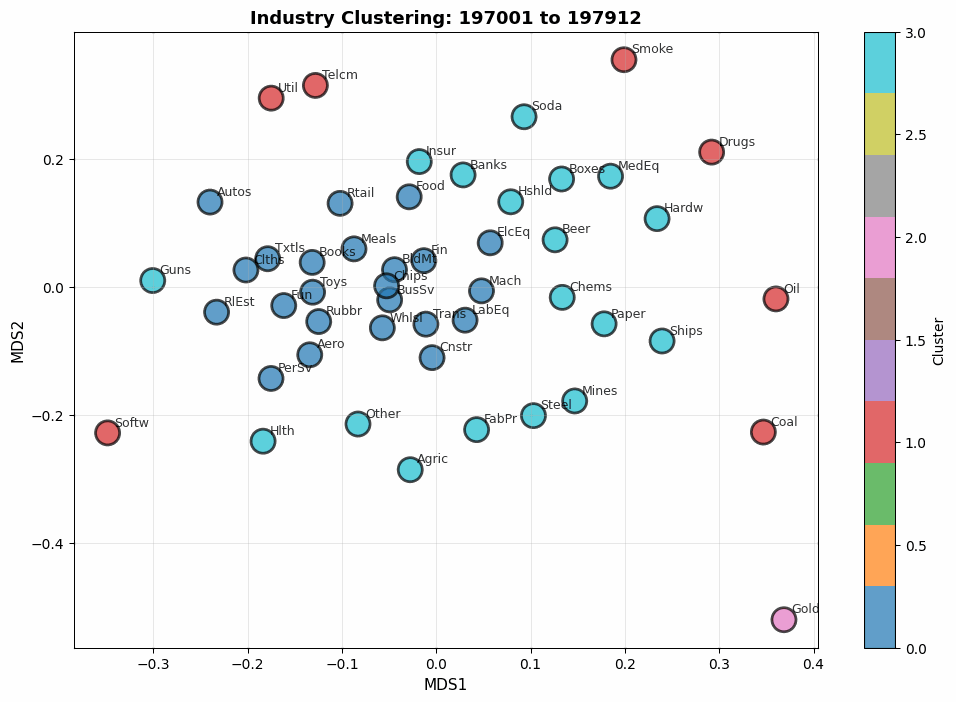

In [27]:
# display the generated GIF in the notebook (if supported)
try:    
    from IPython.display import Image as IPImage
    display(IPImage(filename=output_path))
except ImportError:
    print("IPython not available - cannot display GIF in notebook")